# Coauthorship Network Analysis for Algebraic Topology Publications
### by Line van Nifterik and Stoil Iliev


### Setup

Installing python packages for standard libraries such as pandas, numpy etc, but also for pylatexenc (for parsing LaTeX code & converting to plain text)

In [ ]:
!pip install numpy pandas networkx matplotlib seaborn scipy scikit-learn pylatexenc bibtexparser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=edcd7669ca54c176b1e30fe0101a58ac79f3c116be196375961aad9002f6dacc
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none-any.whl size=43549 sha256=b5bf77fae06e5045f1373330966048598efed25600b5789d9f6396bcf08b2925
  Stored in directory: /root/.cache/pip/wheels/1f/7d/e9/1ff2509f13767a55df1279744adfb757f4ab94b2cbe761f56a
Successfully built pylatexenc bibtexparser


### Imports & uploading bib files

Note that you need to have the bib files locally in order to upload them

In [ ]:
import re
import networkx as nx
import numpy as np
import pandas as pd
import regex
from collections import defaultdict
from typing import Dict, List, Tuple, Optional, Set
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from pylatexenc.latex2text import LatexNodes2Text
import bibtexparser
import warnings
from scipy.sparse.linalg import eigs, inv, eigsh # Import eigs and inv
from scipy.linalg import eig
from scipy.sparse import csc_matrix # Import csc_matrix
from scipy.sparse import eye # Import eye
from sklearn.cluster import KMeans # Import KMeans
warnings.filterwarnings('ignore')

In [ ]:
# Import locally
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

Saving zbmath01.bib to zbmath01.bib
Saving zbmath02.bib to zbmath02.bib
Saving zbmath03.bib to zbmath03.bib
Saving zbmath04.bib to zbmath04.bib
Saving zbmath05.bib to zbmath05.bib
Saving zbmath06.bib to zbmath06.bib
Saving zbmath07.bib to zbmath07.bib
Saving zbmath08.bib to zbmath08.bib
Saving zbmath09.bib to zbmath09.bib
Saving zbmath10.bib to zbmath10.bib
Saving zbmath11.bib to zbmath11.bib
Saving zbmath12.bib to zbmath12.bib
Saving zbmath13.bib to zbmath13.bib
Saving zbmath14.bib to zbmath14.bib
Saving zbmath15.bib to zbmath15.bib
Saving zbmath16.bib to zbmath16.bib
Saving zbmath17.bib to zbmath17.bib
Saving zbmath18.bib to zbmath18.bib
Saving zbmath19.bib to zbmath19.bib
Saving zbmath20.bib to zbmath20.bib
Saving zbmath21.bib to zbmath21.bib
Saving zbmath22.bib to zbmath22.bib
Saving zbmath23.bib to zbmath23.bib
Saving zbmath24.bib to zbmath24.bib
Saving zbmath25.bib to zbmath25.bib
Saving zbmath26.bib to zbmath26.bib
Saving zbmath27.bib to zbmath27.bib
Saving zbmath28.bib to zbmat

###

### Class for building the co-authorship network

In [ ]:
class CoauthorshipNetworkBuilder:
    """
    A class to build coauthorship networks from bibliographic data.
    """

    def __init__(self, data_path: str = "./data"):
        """
        Args:
            data_path: Path to directory containing .bib files
        """
        self.data_path = Path(data_path)
        self.publications = []
        self.author_name_variants = {}  # For handling name variations


    # Name Cleaning (Copied from CoauthorshipNetworkBuilder)
    def normalize_author_name(self, name: str) -> str:
        """
        Normalize author names:
        - Convert LaTeX escapes to Unicode
        - Flip 'Lastname, First' to 'First Last'
        - Remove extra punctuation
        - Prefer full names over initials if multiple forms exist
        """
        # 1. Convert LaTeX -> Unicode (e.g. {\"u} -> ü)
        name = LatexNodes2Text().latex_to_text(name)

        # 2. Clean whitespace
        name = re.sub(r'\s+', ' ', name.strip())

        # 3. Flip 'Lastname, First' -> 'First Last'
        if ',' in name:
            parts = [p.strip() for p in name.split(',', 1)]
            if len(parts) == 2:
                name = f"{parts[1]} {parts[0]}"

        # 4. Remove dots in initials ("D. G." -> "DG")
        name = name.replace('.', '')

        # 5. Normalize capitalization
        tokens = name.split()
        name = " ".join([t.capitalize() for t in tokens])

        # 6. Deduplicate: prefer the longest version encountered
        key = name.lower().replace(" ", "")
        if key in self.author_name_variants:
            current_best = self.author_name_variants[key]
            if len(name) > len(current_best):
                self.author_name_variants[key] = name
            return self.author_name_variants[key]
        else:
            self.author_name_variants[key] = name
            return name

    def merge_author_variants(self):
        """
        Merge variants like 'R Godement' into 'Roger Godement'
        when they share the same last name.
        """
        reverse_map = {}
        for k, name in self.author_name_variants.items():
            parts = name.split()
            if len(parts) >= 2:
                first, last = parts[0], parts[-1]
                for other in self.author_name_variants.values():
                    if other.endswith(last) and other != name:
                        other_first = other.split()[0]
                        # If one is just an initial and the other longer → merge
                        if len(first) == 1 and other_first.startswith(first):
                            reverse_map[name] = other
                        elif len(other_first) == 1 and first.startswith(other_first):
                            reverse_map[other] = name

        # Apply replacements to all publications
        for pub in self.publications:
             # Ensure 'authors' key exists and is a string before splitting
            if 'authors' in pub and isinstance(pub['authors'], str):
                # Split and normalize using the merged names
                authors_list = [a.strip() for a in re.split(r'\s+and\s+', pub['authors']) if a.strip()]
                pub['authors'] = [reverse_map.get(self.normalize_author_name(a), self.normalize_author_name(a)) for a in authors_list]
            elif 'authors' in pub and isinstance(pub['authors'], list):
                 # If authors is already a list (e.g. from prior processing), just apply merge
                pub['authors'] = [reverse_map.get(a, a) for a in pub['authors']]


    def load_bib_files(self, file_pattern: str = "*.bib") -> List[Dict]:
        """
        Load and parse all .bib files from the data directory using bibtexparser.
        Includes author name cleaning and normalization.
        """
        publications = []
        bib_files = list(self.data_path.glob(file_pattern))

        print(f"Found {len(bib_files)} .bib files")

        parser = bibtexparser.bparser.BibTexParser()
        parser.ignore_nonstandard_types = False # Keep all entry types
        parser.homogenise_fields = False # Keep original field names

        temp_publications = [] # Store publications temporarily before merging names

        for bib_file in bib_files:
            try:
                with open(bib_file, 'r', encoding='utf-8', errors='ignore') as f:
                    bib_database = bibtexparser.load(f, parser=parser)
                    for entry in bib_database.entries:
                         # Minimal processing, but apply initial normalization to authors
                        authors_list = []
                        if 'author' in entry and entry['author']:
                            authors_str = entry['author']
                            # Split authors string and normalize each name
                            authors_list = [self.normalize_author_name(a.strip()) for a in re.split(r'\s+and\s+', authors_str) if a.strip()]


                        pub = {
                            'id': entry.get('ID'),
                            'authors': authors_list, # Store as list of normalized names
                            'title': entry.get('title'),     # Keep raw title string for now
                            'year': entry.get('year'),
                            'type': entry.get('ENTRYTYPE')
                        }
                        # Ensure 'authors' and 'year' are present and valid before adding to temp list
                        if pub.get('authors') and pub.get('year'):
                             # Convert year to int if possible
                            try:
                                pub['year'] = int(pub['year'])
                                temp_publications.append(pub)
                            except ValueError:
                                pub['year'] = None
                                # Optionally, skip if year is invalid
                                # pass


            except Exception as e:
                print(f"Error parsing {bib_file}: {e}")

        self.publications = temp_publications # Assign temporary list to publications

        # Now merge author variants based on collected normalized names
        self.merge_author_variants()

        print(f"Loaded {len(self.publications)} publications with cleaned authors")

        years = [p['year'] for p in self.publications if p['year']]
        if years:
            print(f"Year range: {min(years)} - {max(years)}")

        return self.publications


    def create_coauthorship_graph(self,
                                   publications: Optional[List[Dict]] = None,
                                   weighted: bool = True) -> nx.Graph:
        """
        Create a coauthorship graph from publications.

        Args:
            publications: List of publication dictionaries (uses self.publications if None)
            weighted: If True, create weighted edges based on collaboration count

        Returns:
            NetworkX graph representing coauthorship network
        """
        if publications is None:
            publications = self.publications

        if weighted:
            G = nx.Graph()
        else:
            G = nx.Graph()

        # Track collaboration counts for weighted graphs
        collaboration_counts = defaultdict(int)

        for pub in publications:
            authors = pub['authors']

            # Add nodes for all authors
            for author in authors:
                if not G.has_node(author):
                    G.add_node(author)

            # Add edges between all pairs of coauthors
            for i in range(len(authors)):
                for j in range(i + 1, len(authors)):
                    author_pair = tuple(sorted([authors[i], authors[j]]))
                    collaboration_counts[author_pair] += 1

        # Add edges with weights
        for (author1, author2), count in collaboration_counts.items():
            if weighted:
                G.add_edge(author1, author2, weight=count)
            else:
                G.add_edge(author1, author2)

        return G

    def create_temporal_graph(self,
                             t1: int,
                             t2: int,
                             weighted: bool = True) -> nx.Graph:
        """
        Create a coauthorship graph for a specific time period.

        Args:
            t1: Start year (inclusive)
            t2: End year (inclusive)
            weighted: If True, create weighted edges

        Returns:
            NetworkX graph for the specified time period
        """
        # Filter publications by time period
        filtered_pubs = [
            pub for pub in self.publications
            if pub['year'] and t1 <= pub['year'] <= t2
        ]

        print(f"Creating graph for period [{t1}, {t2}]: {len(filtered_pubs)} publications")

        return self.create_coauthorship_graph(filtered_pubs, weighted)

    def analyze_graph_statistics(self, G: nx.Graph) -> Dict:
        """
        Calculate basic statistics for a graph.

        Args:
            G: NetworkX graph

        Returns:
            Dictionary with graph statistics
        """
        stats = {
            'num_nodes': G.number_of_nodes(),
            'num_edges': G.number_of_edges(),
            'density': nx.density(G),
            'num_components': nx.number_connected_components(G)
        }

        if G.number_of_nodes() > 0:
            # Get largest connected component
            largest_cc = max(nx.connected_components(G), key=len)
            stats['largest_component_size'] = len(largest_cc)
            stats['largest_component_fraction'] = len(largest_cc) / G.number_of_nodes()

            # Degree statistics
            degrees = dict(G.degree())
            stats['avg_degree'] = np.mean(list(degrees.values()))
            stats['max_degree'] = max(degrees.values())
            stats['min_degree'] = min(degrees.values())

            # Find most connected authors
            top_authors = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]
            stats['top_authors'] = top_authors

        return stats

    def visualize_graph_evolution(self,
                                  time_windows: List[Tuple[int, int]],
                                  save_path: Optional[str] = None):
        """
        Visualize how the network evolves over time.

        Args:
            time_windows: List of (start_year, end_year) tuples
            save_path: Path to save the figure
        """
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Coauthorship Network Evolution', fontsize=16)

        metrics = {
            'nodes': [],
            'edges': [],
            'density': [],
            'largest_cc': [],
            'avg_degree': []
        }

        for (t1, t2) in time_windows:
            G = self.create_temporal_graph(t1, t2)
            stats = self.analyze_graph_statistics(G)

            metrics['nodes'].append(stats['num_nodes'])
            metrics['edges'].append(stats['num_edges'])
            metrics['density'].append(stats['density'])
            metrics['largest_cc'].append(stats.get('largest_component_fraction', 0))
            metrics['avg_degree'].append(stats.get('avg_degree', 0))

        # Create time labels
        time_labels = [f"{t1}-{t2}" for t1, t2 in time_windows]

        # Plot metrics
        axes[0, 0].plot(metrics['nodes'], 'o-')
        axes[0, 0].set_title('Number of Authors')
        axes[0, 0].set_xlabel('Time Period')
        axes[0, 0].set_xticks(range(len(time_labels)))
        axes[0, 0].set_xticklabels(time_labels, rotation=45)

        axes[0, 1].plot(metrics['edges'], 'o-', color='orange')
        axes[0, 1].set_title('Number of Collaborations')
        axes[0, 1].set_xlabel('Time Period')
        axes[0, 1].set_xticks(range(len(time_labels)))
        axes[0, 1].set_xticklabels(time_labels, rotation=45)

        axes[0, 2].plot(metrics['density'], 'o-', color='green')
        axes[0, 2].set_title('Network Density')
        axes[0, 2].set_xlabel('Time Period')
        axes[0, 2].set_xticks(range(len(time_labels)))
        axes[0, 2].set_xticklabels(time_labels, rotation=45)

        axes[1, 0].plot(metrics['largest_cc'], 'o-', color='red')
        axes[1, 0].set_title('Largest Component Fraction')
        axes[1, 0].set_xlabel('Time Period')
        axes[1, 0].set_xticks(range(len(time_labels)))
        axes[1, 0].set_xticklabels(time_labels, rotation=45)

        axes[1, 1].plot(metrics['avg_degree'], 'o-', color='purple')
        axes[1, 1].set_title('Average Degree')
        axes[1, 1].set_xlabel('Time Period')
        axes[1, 1].set_xticks(range(len(time_labels)))
        axes[1, 1].set_xticklabels(time_labels, rotation=45)

        # Hide the last subplot
        axes[1, 2].axis('off')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

### Initialize builder, load publications


In [ ]:
builder = CoauthorshipNetworkBuilder(data_path="/content/")
publications = builder.load_bib_files()

Found 85 .bib files
Loaded 361584 publications with cleaned authors
Year range: 1936 - 2023


### Create static graph

In [ ]:

G_static = builder.create_coauthorship_graph(weighted=True)
static_stats = builder.analyze_graph_statistics(G_static)
static_stats

{'num_nodes': 5415,
 'num_edges': 5580,
 'density': 0.0003806689745576002,
 'num_components': 2273,
 'largest_component_size': 1869,
 'largest_component_fraction': 0.34515235457063714,
 'avg_degree': np.float64(2.0609418282548475),
 'max_degree': 41,
 'min_degree': 0,
 'top_authors': [('Bei Wang', 41),
  ('Talha Bin Masood', 34),
  ('Martin Falk', 34),
  ('Julien Tierny', 33),
  ('Christoph Garth', 32),
  ('Petar Hristov', 32),
  ('Nigel Ray', 31),
  ('Jonas Lukasczyk', 31),
  ('Lutz Hofmann', 31),
  ('Brittany Terese Fasy', 30)]}

### Show top authors

In [ ]:
print("\nTop 10 most connected authors:")
for author, degree in static_stats['top_authors']:
    print(f"  - {author}: {degree} collaborators")


Top 10 most connected authors:
  - Bei Wang: 41 collaborators
  - Talha Bin Masood: 34 collaborators
  - Martin Falk: 34 collaborators
  - Julien Tierny: 33 collaborators
  - Christoph Garth: 32 collaborators
  - Petar Hristov: 32 collaborators
  - Nigel Ray: 31 collaborators
  - Jonas Lukasczyk: 31 collaborators
  - Lutz Hofmann: 31 collaborators
  - Brittany Terese Fasy: 30 collaborators


### Temporal graphs

In [ ]:
time_windows = [
    (1936, 1960),
    (1961, 1980),
    (1981, 2000),
    (2001, 2010),
    (2011, 2020),
    (2021, 2023)
]

for t1, t2 in time_windows:
    G_temporal = builder.create_temporal_graph(t1, t2, weighted=True)
    temp_stats = builder.analyze_graph_statistics(G_temporal)
    print(f"\nPeriod [{t1}, {t2}]:")
    print(f"  - Authors: {temp_stats['num_nodes']}")
    print(f"  - Collaborations: {temp_stats['num_edges']}")
    print(f"  - Avg degree: {temp_stats.get('avg_degree', 0):.2f}")

Creating graph for period [1936, 1960]: 30 publications

Period [1936, 1960]:
  - Authors: 17
  - Collaborations: 4
  - Avg degree: 0.47
Creating graph for period [1961, 1980]: 3146 publications

Period [1961, 1980]:
  - Authors: 953
  - Collaborations: 252
  - Avg degree: 0.53
Creating graph for period [1981, 2000]: 5730 publications

Period [1981, 2000]:
  - Authors: 1783
  - Collaborations: 929
  - Avg degree: 1.04
Creating graph for period [2001, 2010]: 2836 publications

Period [2001, 2010]:
  - Authors: 1172
  - Collaborations: 746
  - Avg degree: 1.27
Creating graph for period [2011, 2020]: 3904 publications

Period [2011, 2020]:
  - Authors: 1900
  - Collaborations: 1893
  - Avg degree: 1.99
Creating graph for period [2021, 2023]: 1196 publications

Period [2021, 2023]:
  - Authors: 909
  - Collaborations: 1064
  - Avg degree: 2.34


### Visualizations

Creating graph for period [1936, 1960]: 15 publications
Creating graph for period [1961, 1980]: 1573 publications
Creating graph for period [1981, 2000]: 2865 publications
Creating graph for period [2001, 2010]: 1418 publications
Creating graph for period [2011, 2020]: 1952 publications
Creating graph for period [2021, 2023]: 598 publications


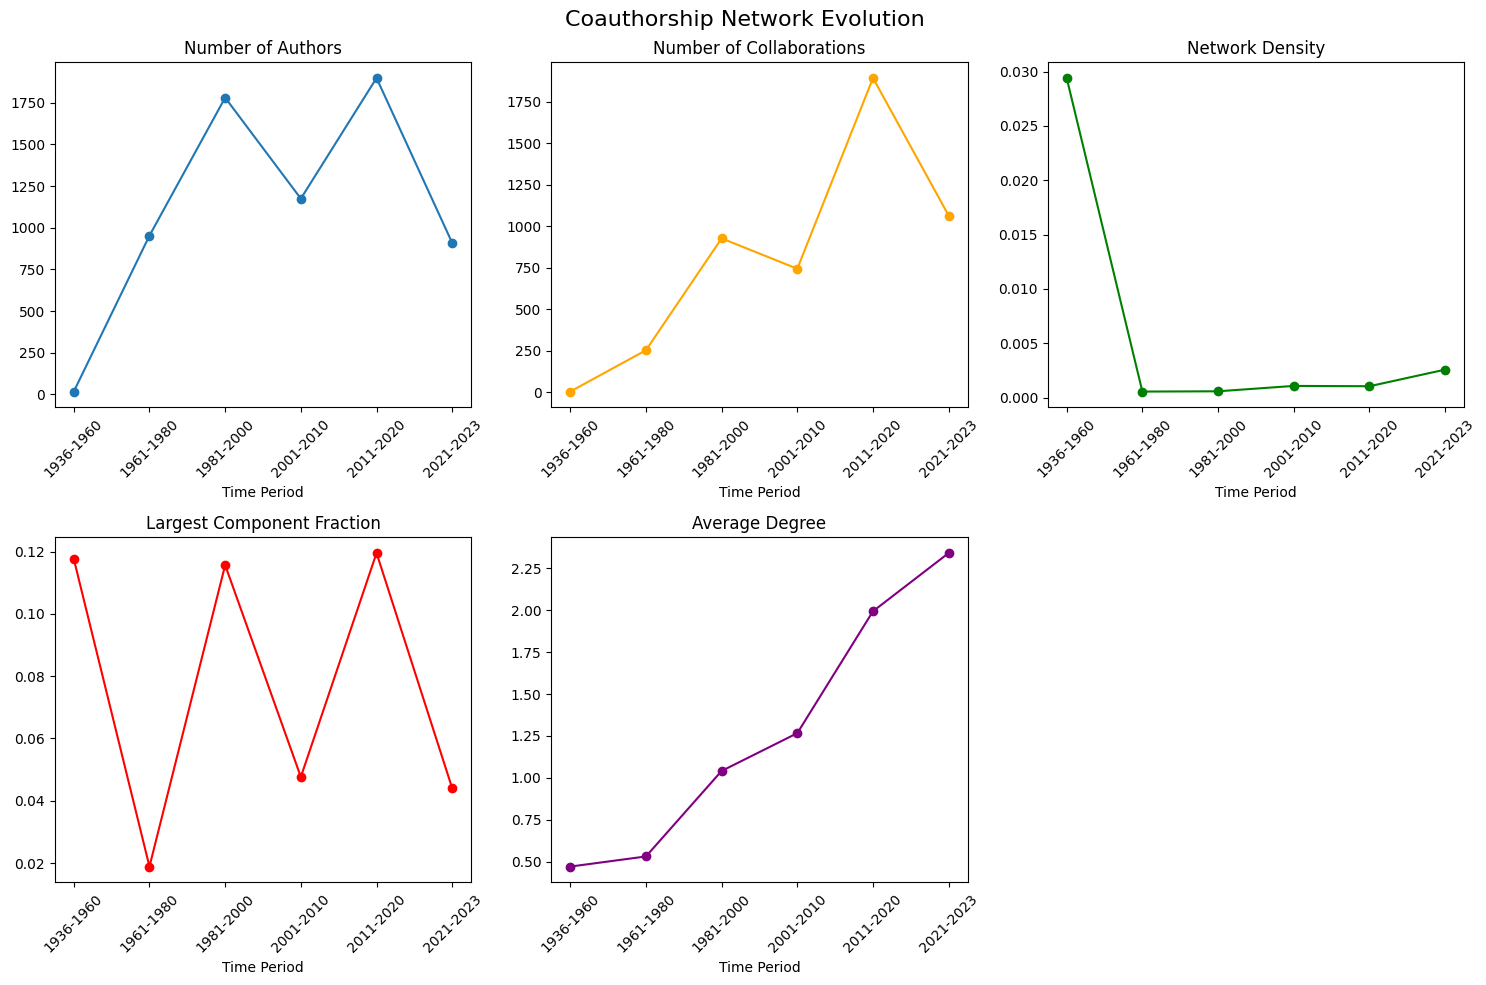

In [ ]:
builder.visualize_graph_evolution(time_windows)

### Visualize the static graph (full data)

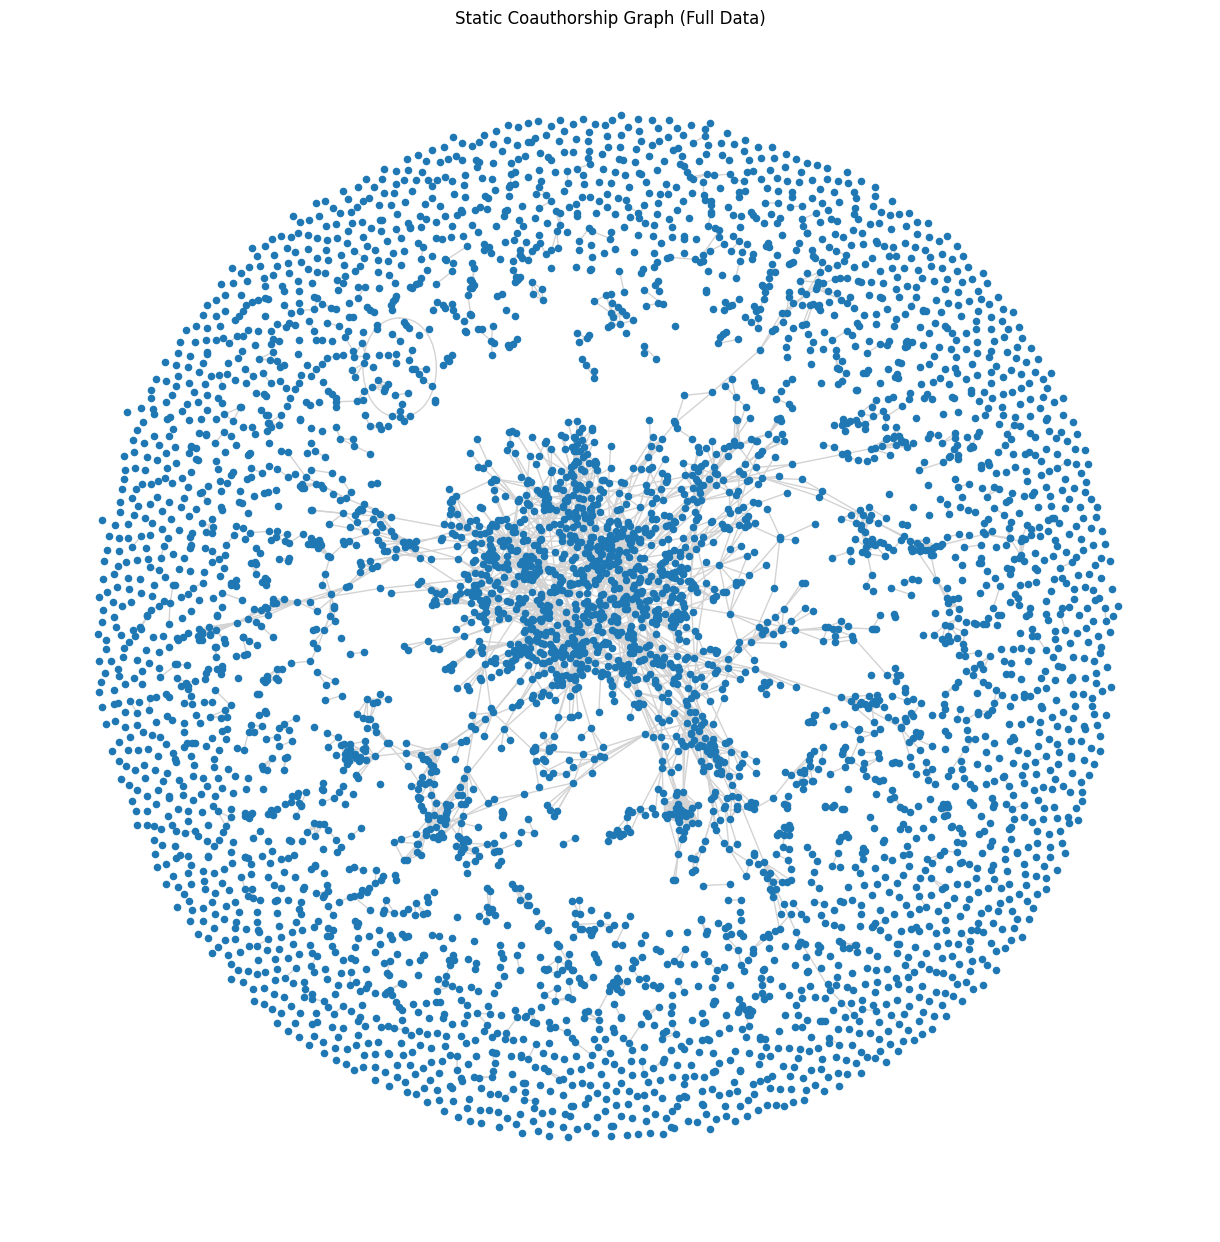

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_static)  # You can choose different layout algorithms
nx.draw(G_static, pos, with_labels=False, node_size=20, edge_color='lightgray')
plt.title("Static Coauthorship Graph (Full Data)")
plt.show()

### Visualize a temporal graph (example: 2021-2023)


Creating graph for period [2021, 2023]: 598 publications


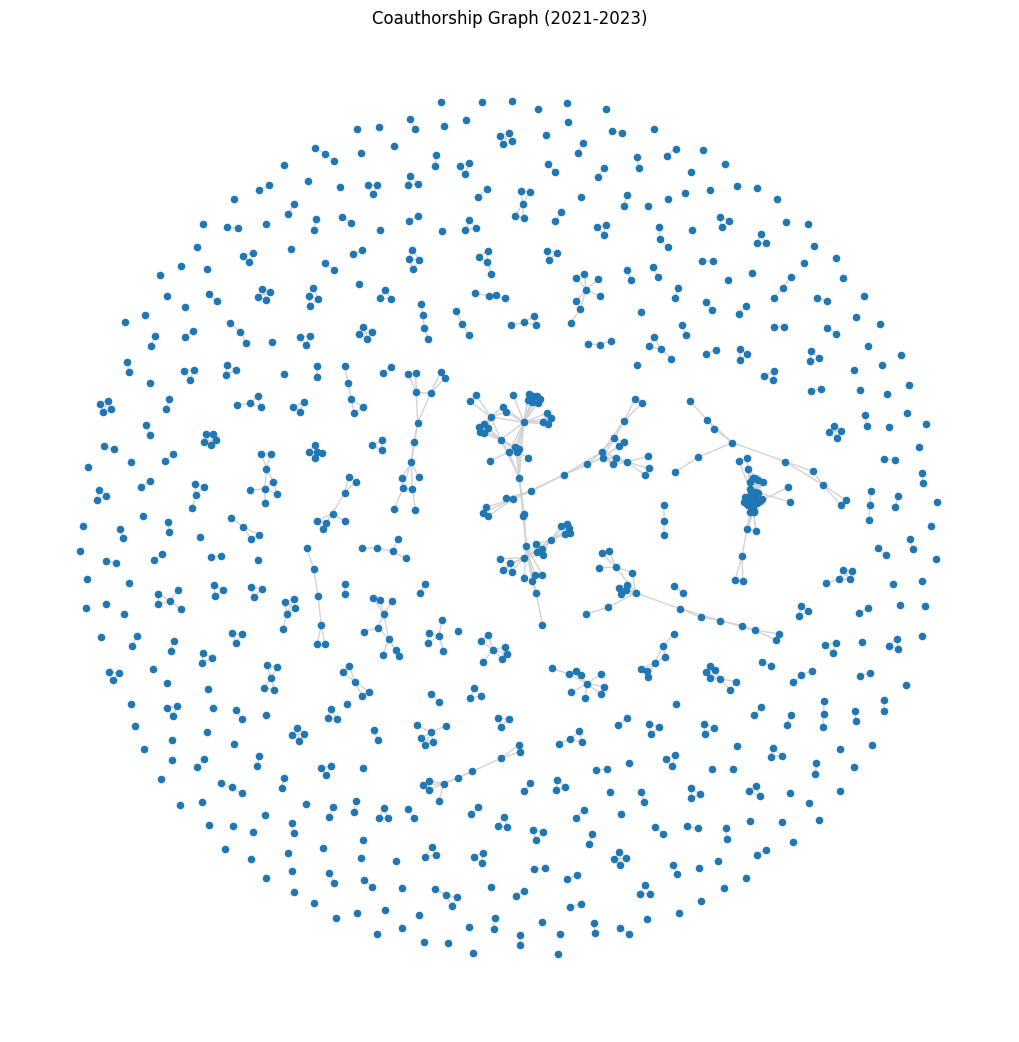

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

G_temporal_latest = builder.create_temporal_graph(2021, 2023, weighted=False) # Weighted edges can clutter visualization

plt.figure(figsize=(10, 10))
pos_temp = nx.spring_layout(G_temporal_latest)
nx.draw(G_temporal_latest, pos_temp, with_labels=False, node_size=20, edge_color='lightgray')
plt.title("Coauthorship Graph (2021-2023)")
plt.show()

Getting adjacency and Laplacian matrices

In [ ]:
def get_A(G):
    A = nx.adjacency_matrix(G)
    A = A.astype('float')
    return(A)

def get_norm_L(G):
    L = nx.normalized_laplacian_matrix(G, weight=None)
    L = L.astype('float')
    return(L)

**Centrality measures**

In [ ]:
# def get_eigenvector_centrality(G):
#     n = G.number_of_nodes()
#     A = get_A(G)
#     lam, v = eigs(A,1) # computes 1 eigenvalue and its corresponding eigenvector
#     lam = lam.real # Takes the real part of the eigenvalue.
#     v = abs(v.real) # takes the real part of the eigenvector and applies abs elementwise
#     eigenvector_centrality = np.empty(n)
#     for i in range(n):
#         eigenvector_centrality[i] = 1/lam*v[i]
#     return eigenvector_centrality

def get_eigenvector_centrality(G):
    n = G.number_of_nodes()
    A = get_A(G)
    if n < 3:  # small graphs dense eigendecomposition
        lam, v = eig(A.toarray())
        idx = np.argmax(lam.real)
        v = np.abs(v[:, idx].real)
        lam = lam[idx].real
    else:  # larger graphs → use sparse eigs
        lam, v = eigs(A, k=1)
        lam = lam.real[0]
        v = np.abs(v[:, 0].real)

    eigenvector_centrality = v / lam
    return eigenvector_centrality


# def get_largest_egvalue(G):
#     A = get_A(G)
#     eigv, _ = eigs(A, k=1, which='LR')  # LR = Largest Real part
#     largest_eigenvalue = np.real(eigv[0])
#     inv_eig = 1/largest_eigenvalue
#     return largest_eigenvalue, inv_eig

def get_largest_egvalue(G):
    A = get_A(G)
    n = G.number_of_nodes()

    if n < 3:
        eigvals, _ = eig(A.toarray())
        eigvals = eigvals.real
        largest_eigenvalue = np.max(eigvals)
    else:
        eigv, _ = eigs(A, k=1, which='LR')
        largest_eigenvalue = np.real(eigv[0])

    inv_eig = 1 / largest_eigenvalue if largest_eigenvalue > 0 else np.inf
    return largest_eigenvalue, inv_eig


def get_res_sub_centrality(G, alpha):
    n = G.number_of_nodes()
    A = get_A(G)
    I = eye(n)
    M = I-alpha*A
    # data structure in the SciPy library used to efficiently store and manipulate sparse matrices in Compressed Sparse Column (CSC) format.
    M = csc_matrix(M)

    resolvent = inv(M)

    resolvent_subgraph_centrality = np.empty(n)
    for i in range(n):
        resolvent_subgraph_centrality[i] = resolvent[i,i]
    return resolvent_subgraph_centrality

Getting the authors associated to biggest centrality scores

In [ ]:
def top_authors_res_sub_cent(G, alpha, m):
    aut = {}
    nodes = list(G.nodes())
    centrality = get_res_sub_centrality(G, alpha)

    # Map each node to its centrality

    node_centrality = {nodes[i]: centrality[i] for i in range(len(nodes))}
    top_m = sorted(node_centrality.items(), key=lambda x: x[1], reverse=True)[:m]
    for author, score in top_m:
        aut[author] = float(score)
    return aut

In [ ]:
def top_authors_eig_cent(G, m):
    aut = {}
    nodes = list(G.nodes())
    centrality = get_eigenvector_centrality(G)

    # Map each node to its centrality

    node_centrality = {nodes[i]: centrality[i] for i in range(len(nodes))}
    top_m = sorted(node_centrality.items(), key=lambda x: x[1], reverse=True)[:m]
    for author, score in top_m:
        aut[author] = float(score)
    return aut

Plotting with centrality scores

In [ ]:
def plot_eig_cent_graph(G, eigenvector_centrality):
    cmap = 'jet'
    pos = nx.spring_layout(G, seed=1)
    plt.figure(figsize=(30, 20))

    # Draw nodes
    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_size=75,
        node_color=eigenvector_centrality,
        cmap=cmap
    )
    nx.draw_networkx_edges(G, pos, alpha=0.2)

    # Add colorbar linked to the nodes
    plt.colorbar(nodes)
    plt.title("Eigenvector centrality")
    plt.axis("off")
    plt.show()

In [ ]:
# def plot_cent_graph(G, eigenvector_centrality, resolvent_subgraph_centrality):
#     cmap='jet'
#     # pos = nx.kamada_kawai_layout(G)
#     pos = nx.spring_layout(G, seed=1)
#     plt.figure(figsize=(30,20))
#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(eigenvector_centrality), vmax=max(eigenvector_centrality)))
#     sm._A = []
#     # plt.colorbar(sm)
#     nx.draw(G, pos, node_size=75, node_color=resolvent_subgraph_centrality, cmap=cmap)

In [ ]:
def plot_res_cent_graph(G, resolvent_subgraph_centrality):
    cmap = 'jet'
    pos = nx.spring_layout(G, seed=1)
    plt.figure(figsize=(30, 20))

    # Draw nodes colored by resolvent subgraph centrality
    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_size=75,
        node_color=resolvent_subgraph_centrality,
        cmap=cmap
    )
    nx.draw_networkx_edges(G, pos, alpha=0.2)

    # Add colorbar linked to the node colors
    plt.colorbar(nodes)
    plt.title("Resolvent centrality")
    plt.axis("off")
    plt.show()

Most "important" authors for a given decade


In [ ]:
print("Most important authors per time window, using eigenvector centrality:")
for t1, t2 in time_windows:
  G = builder.create_temporal_graph(t1, t2, weighted=True)
  print(f"\nPeriod [{t1}, {t2}]:")
  top_authors = top_authors_eig_cent(G,5)
  print(f"Top 5 authors for period {t1} - {t2}: {top_authors}")

Most important authors per time window, using eigenvector centrality:
Creating graph for period [1936, 1960]: 15 publications

Period [1936, 1960]:
Top 5 authors for period 1936 - 1960: {'J L Kelley': 0.5631336797998427, 'Everett Pitcher': 0.5631336797998427, 'Patrick Shanahan': 0.34907644923754344, 'J W T Youngs': 0.34907644923754344, 'E A Barbashin': 0.18937694128010282}
Creating graph for period [1961, 1980]: 1573 publications

Period [1961, 1980]:
Top 5 authors for period 1961 - 1980: {'W Stephen Wilson': 0.08972770122535374, 'Haynes R Miller': 0.06760818421973107, 'Douglas C Ravenel': 0.06760818421973107, 'David Copeland Johnson': 0.03830878799965554, 'Zen-ichi Yosimura': 0.005562362517762345}
Creating graph for period [1981, 2000]: 2865 publications

Period [1981, 2000]:
Top 5 authors for period 1981 - 2000: {"M A Shtan'ko": 0.040328275582227006, 'N P Dolbilin': 0.040328275582226965, 'M I Shtogrin': 0.040328275582226965, 'A G Sedrakyan': 0.008513401849934628, 'Mark Mahowald': 1.5

In [ ]:
# # Get the number of nodes from the full static graph for centrality calc.
# n = G_static.number_of_nodes()

print("Most important authors per time window, using resolvent subgraph centrality:")
for t1, t2 in time_windows:
  G = builder.create_temporal_graph(t1, t2, weighted=True)

  # Calculate inverse of largest eigenvalue to determine alpha range
  largest_eigenvalue, inv_eig = get_largest_egvalue(G)
  alpha = np.random.uniform(0, inv_eig)
  print(f"\nPeriod [{t1}, {t2}]:")
  print(f"  - Alpha: {alpha}")
  top_authors = top_authors_res_sub_cent(G, alpha, 5)
  print(f"Top 5 authors for period {t1} - {t2}: {top_authors}")


Most important authors per time window, using resolvant subgraph centrality:
Creating graph for period [1936, 1960]: 15 publications

Period [1936, 1960]:
  - Alpha: 0.3949060492300891
Top 5 authors for period 1936 - 1960: {'Patrick Shanahan': 1.1847650414801991, 'J W T Youngs': 1.1847650414801991, 'Peter J Hilton': 1.1847650414801991, 'S Wylie': 1.1847650414801991, 'E A Barbashin': 1.1847650414801991}
Creating graph for period [1961, 1980]: 1573 publications

Period [1961, 1980]:
  - Alpha: 0.036877801851708684
Top 5 authors for period 1961 - 1980: {"Vladimir I Kuz'minov": 1.0776774033481553, 'Igor A Shvedov': 1.0718149578124454, 'W Stephen Wilson': 1.0629903446264235, 'Aristide Deleanu': 1.0514793807904794, 'Peter Hilton': 1.0514793807904794}
Creating graph for period [1981, 2000]: 2865 publications

Period [1981, 2000]:
  - Alpha: 0.022924363482953684
Top 5 authors for period 1981 - 2000: {'N P Dolbilin': 1.0664973618500797, 'M I Shtogrin': 1.0664973618500797, "M A Shtan'ko": 1.0664

We draw the graphs with centrality scores for a few periods of time

Creating graph for period [2021, 2023]: 598 publications


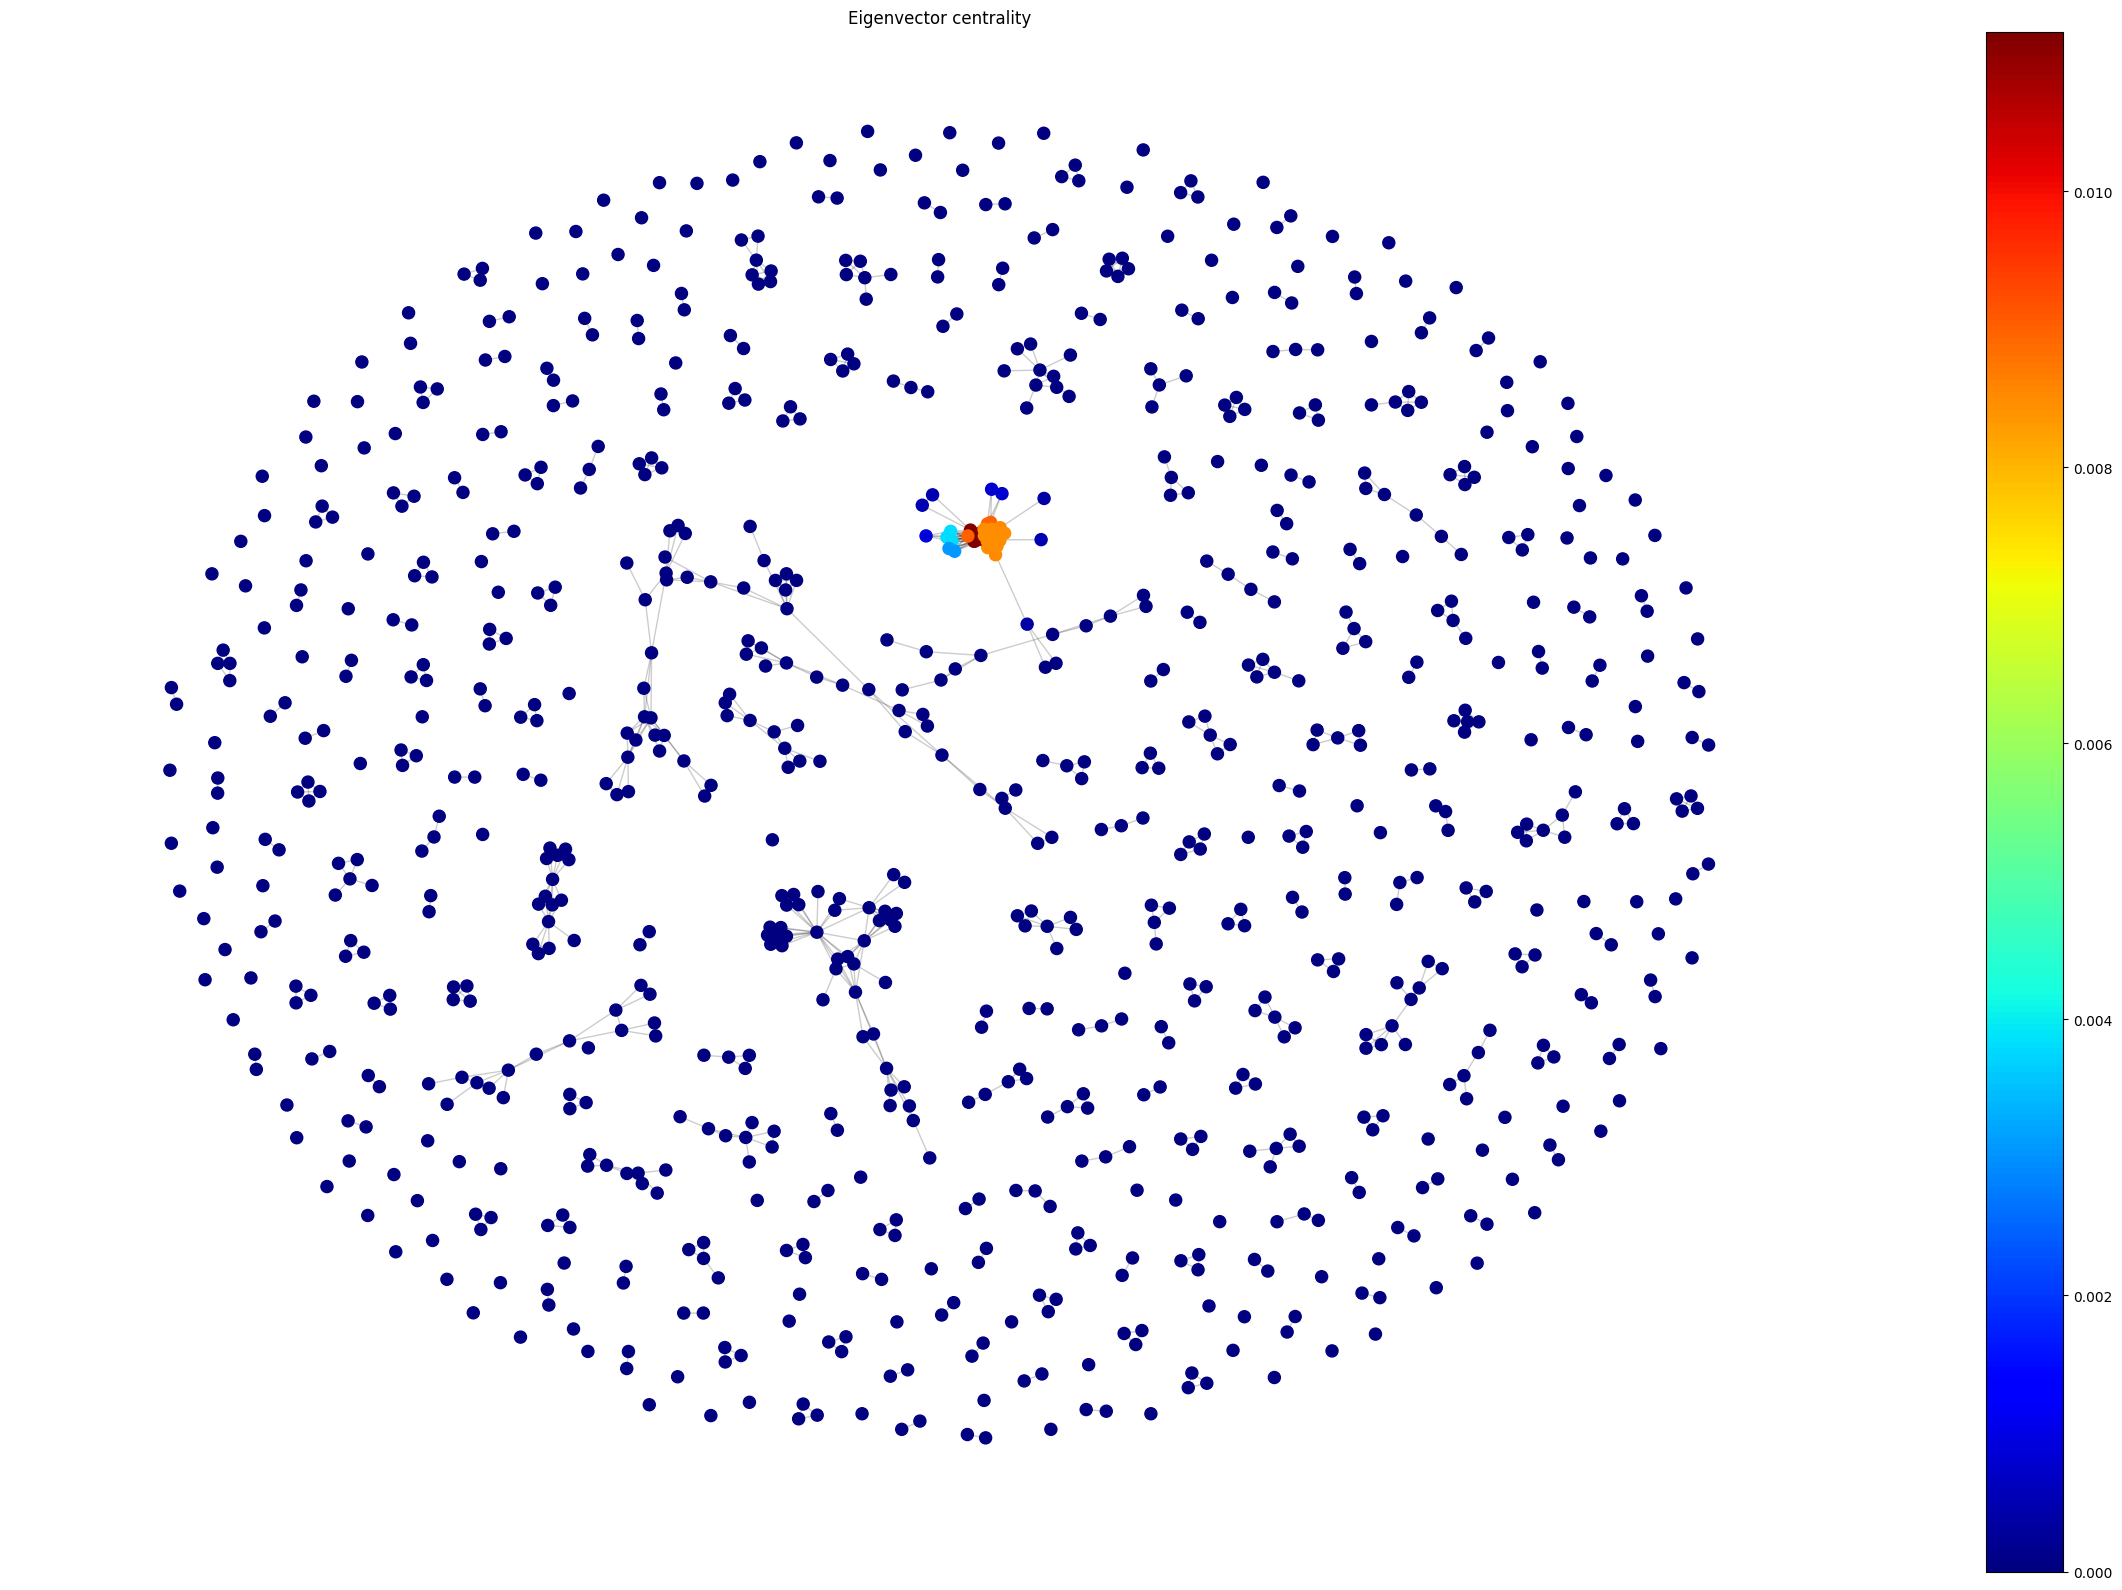

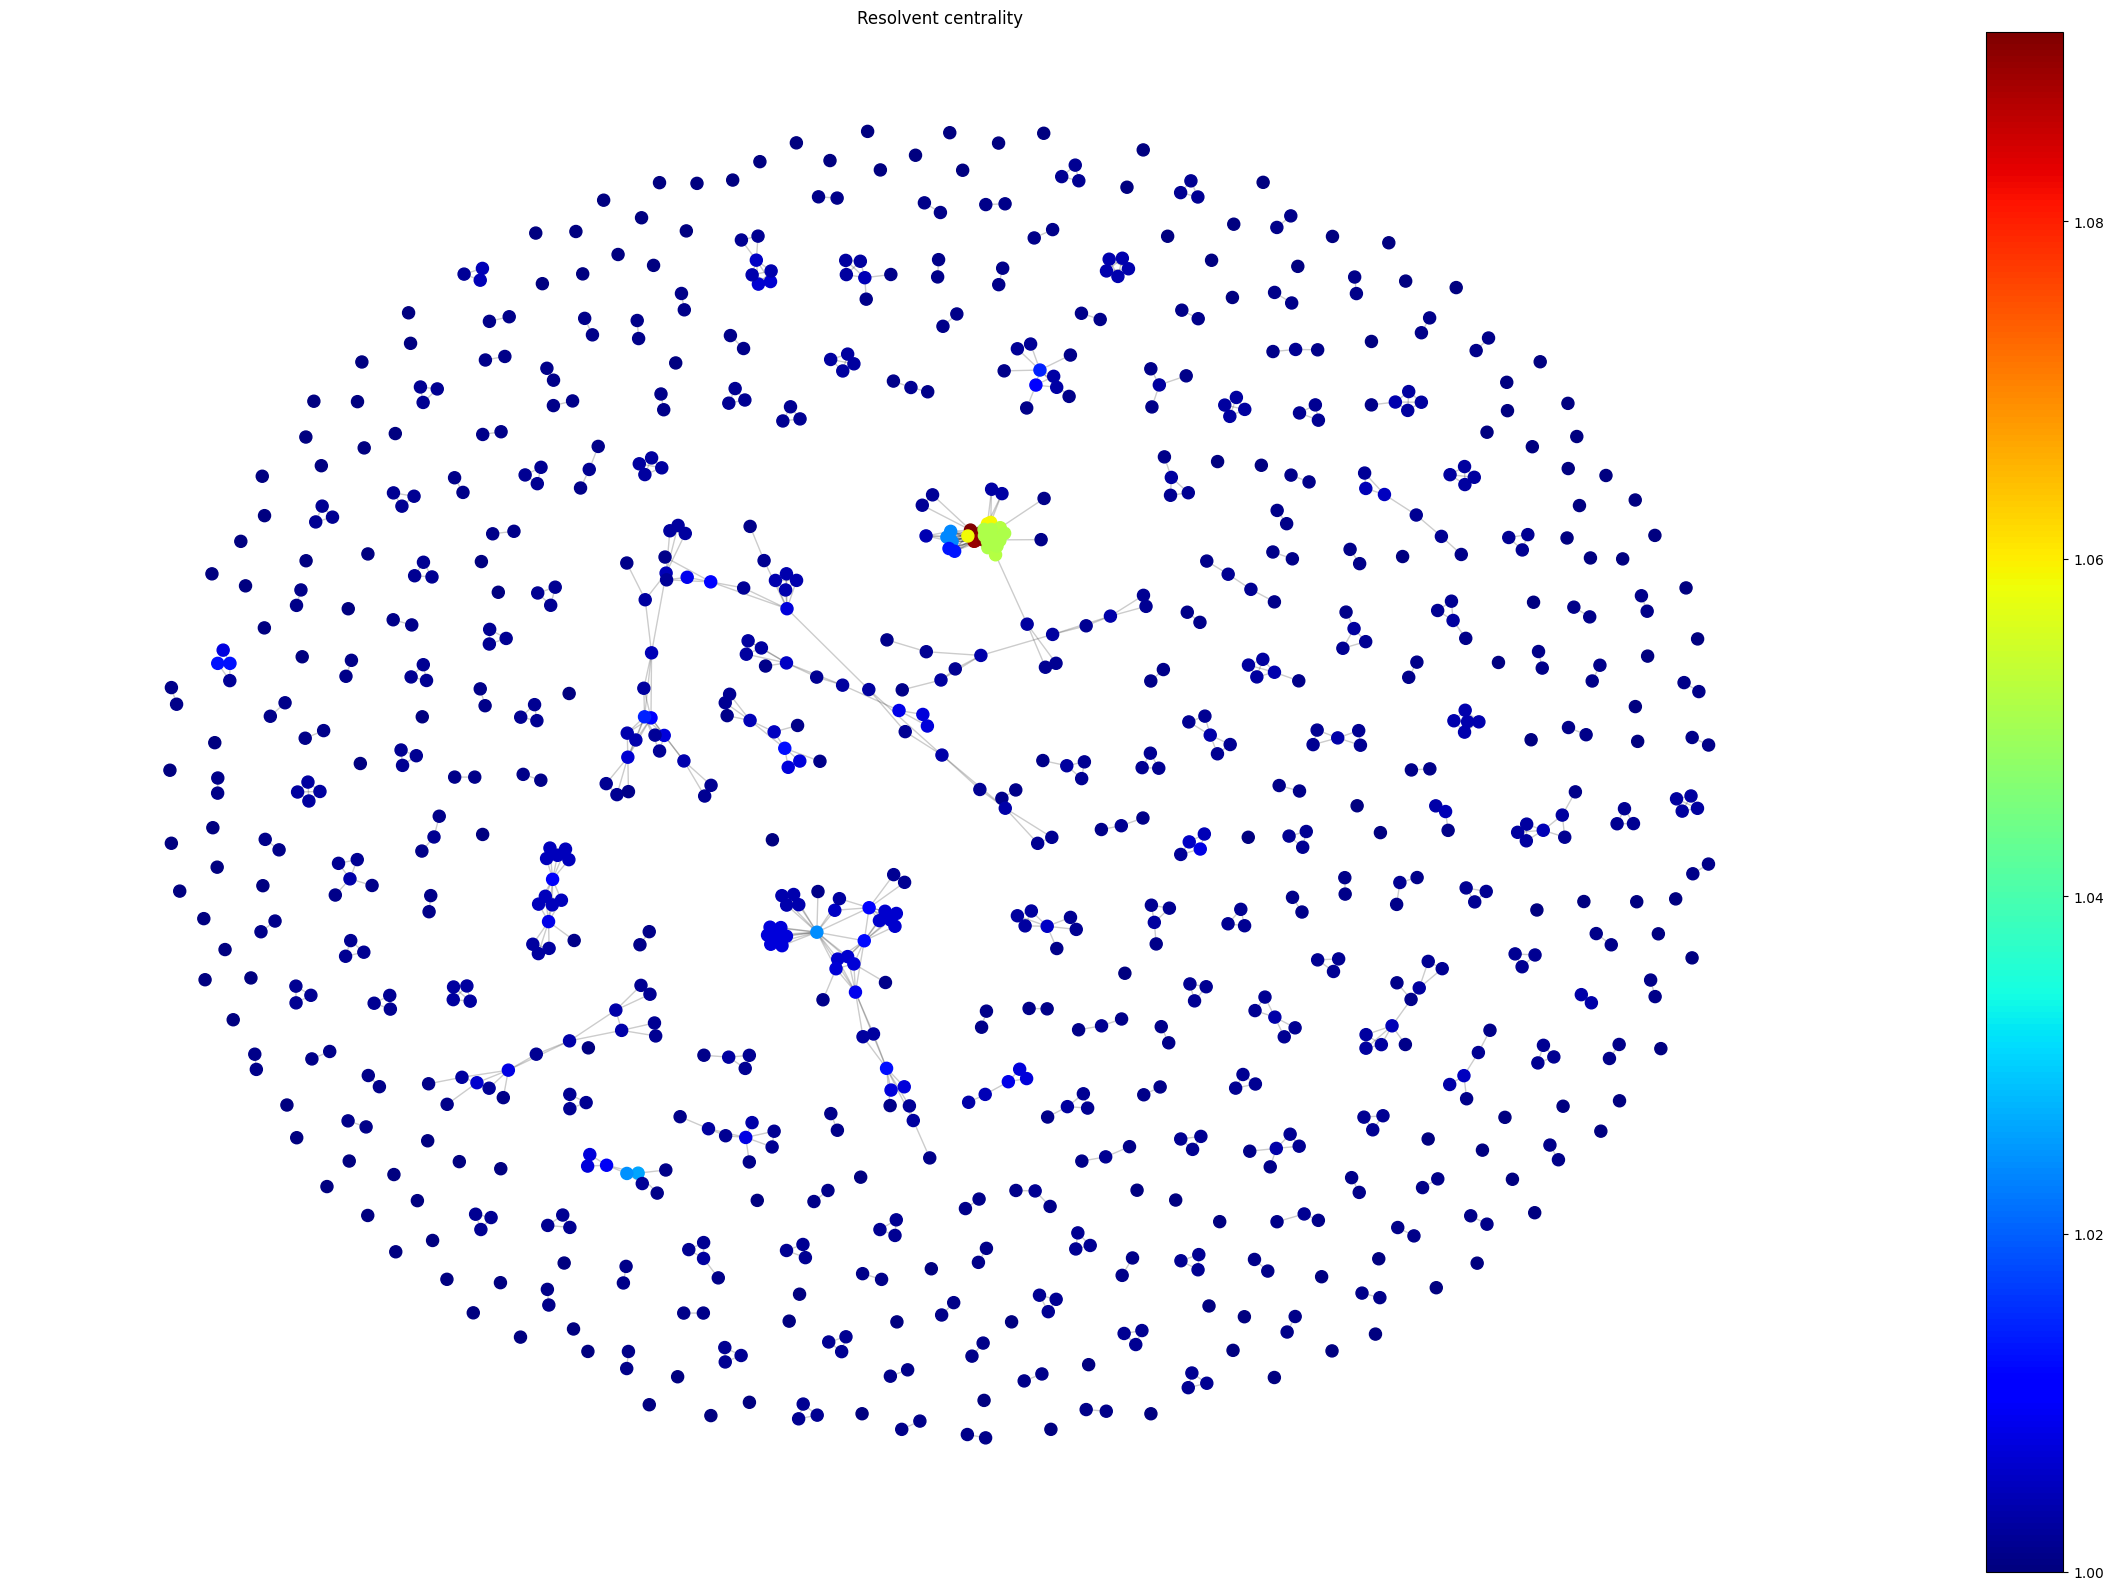

In [ ]:
t1, t2 = 2021, 2023
G_1 = builder.create_temporal_graph(t1, t2, weighted=True)
alpha_1 = 0.0293 # alpha given by previous code for this time period
eigenvector_centrality_1 = get_eigenvector_centrality(G_1)
resolvent_sub_cent_1 = get_res_sub_centrality(G_1, alpha_1)
plot_eig_cent_graph(G_1, eigenvector_centrality_1 )
plot_res_cent_graph(G_1, resolvent_sub_cent_1)


Creating graph for period [1936, 1960]: 15 publications


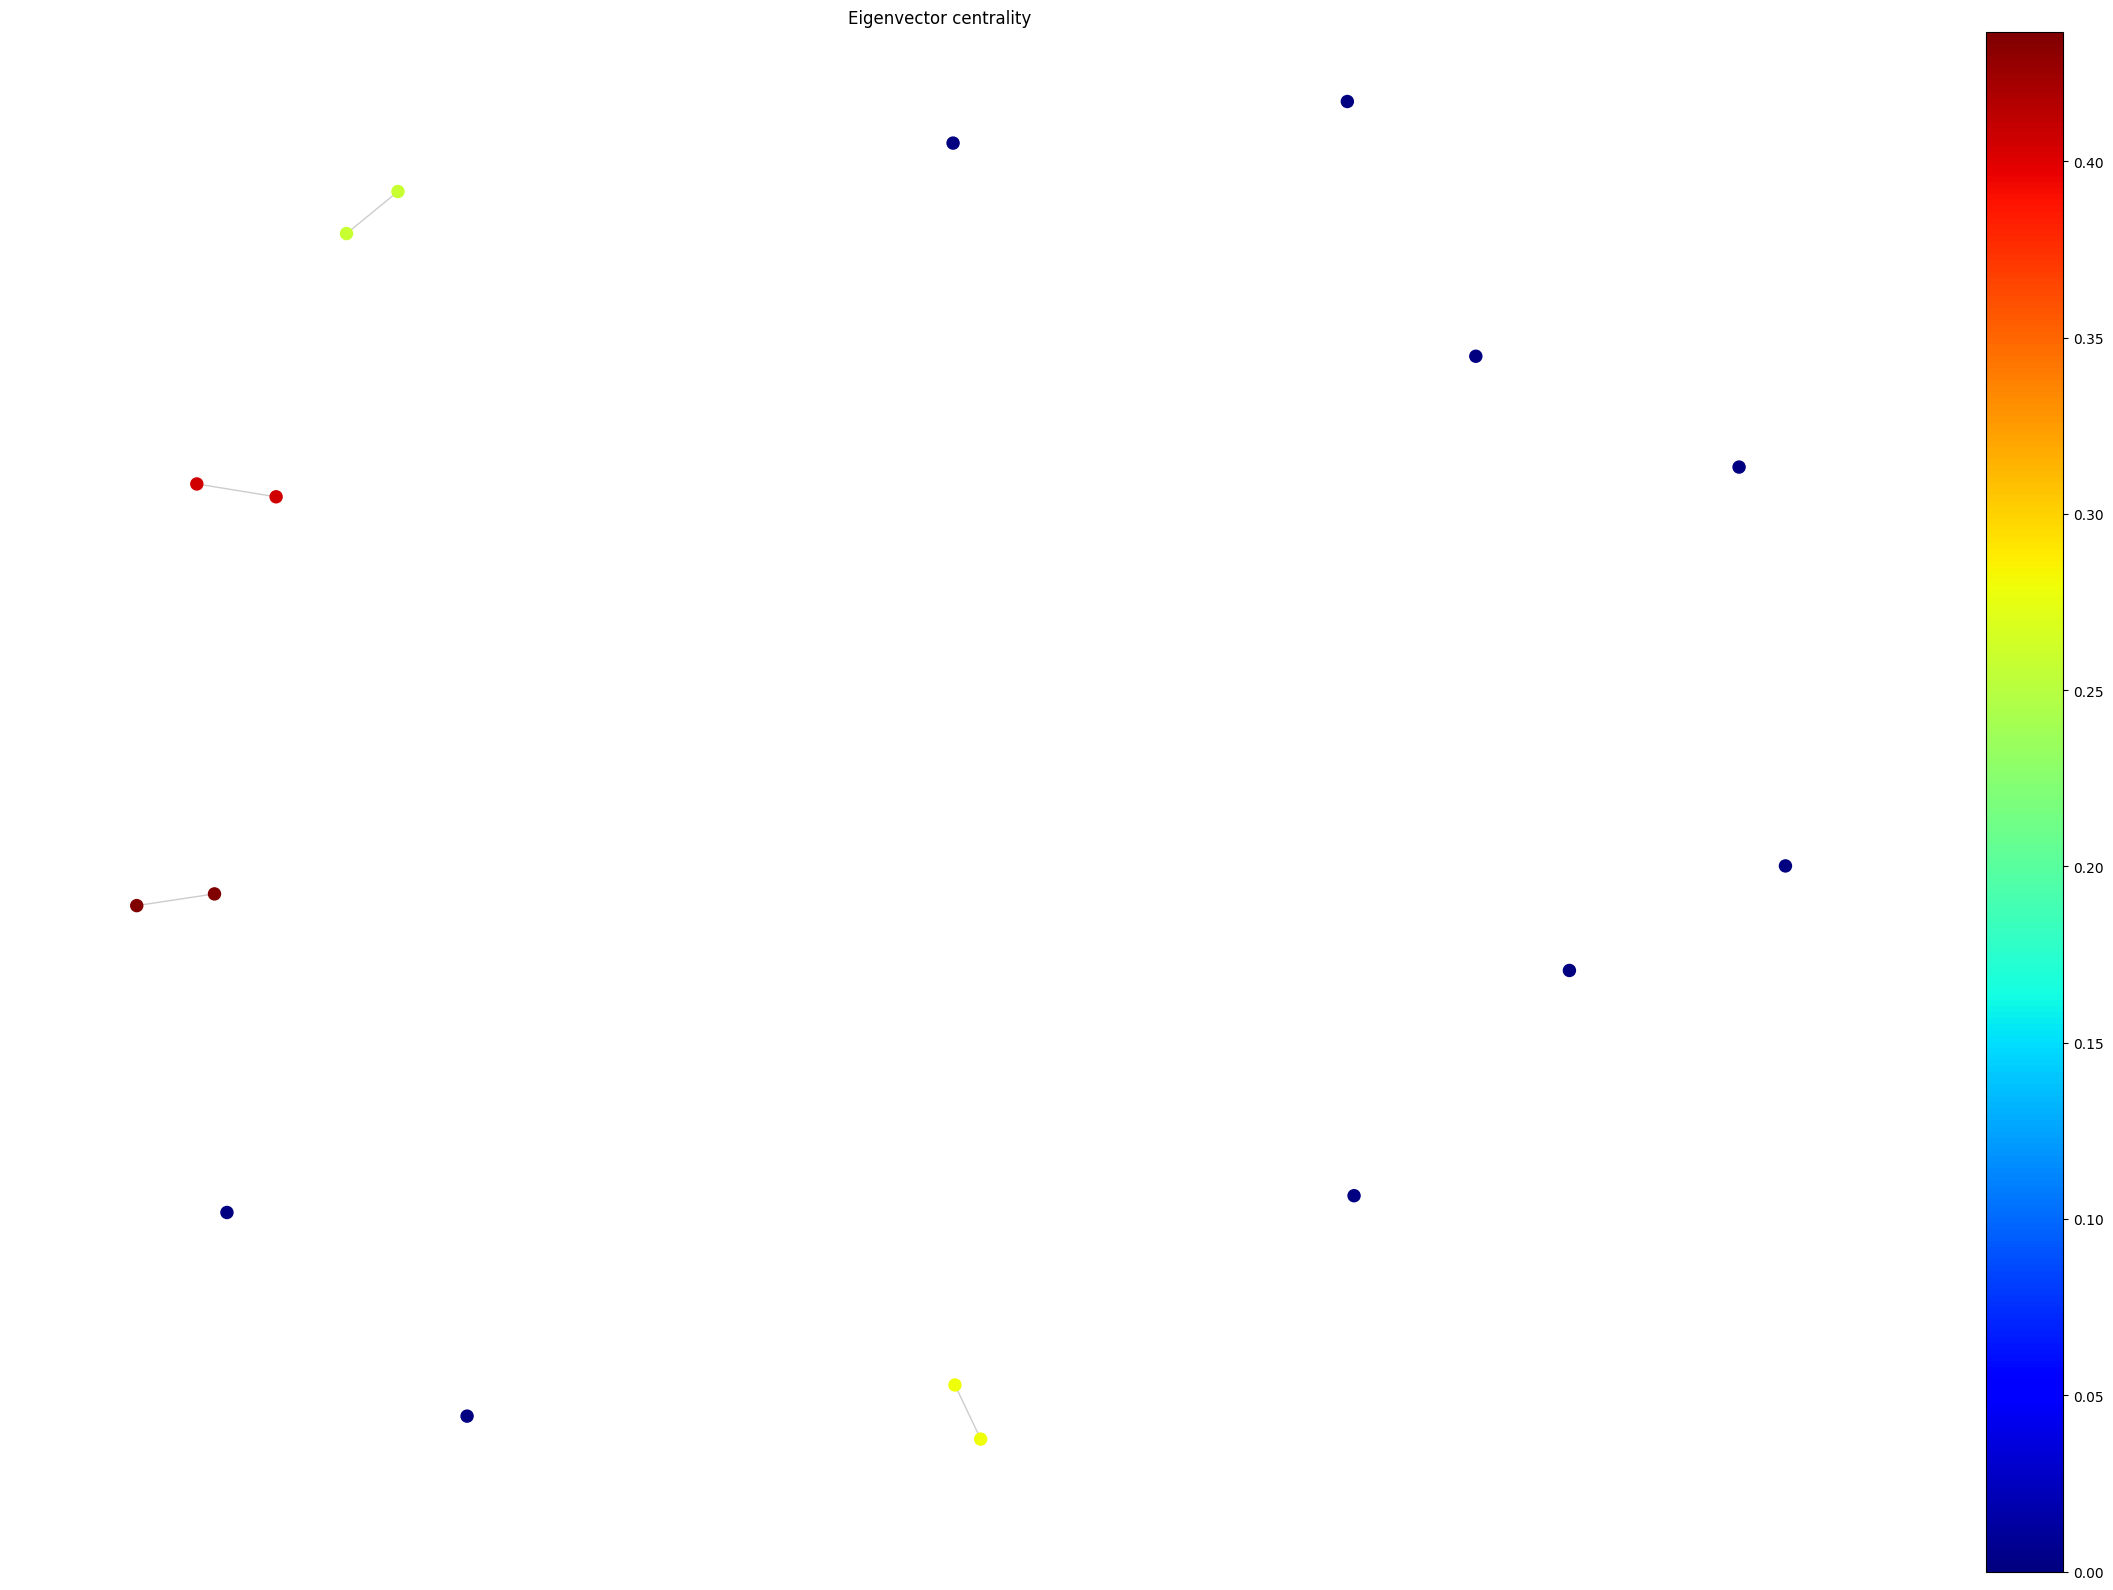

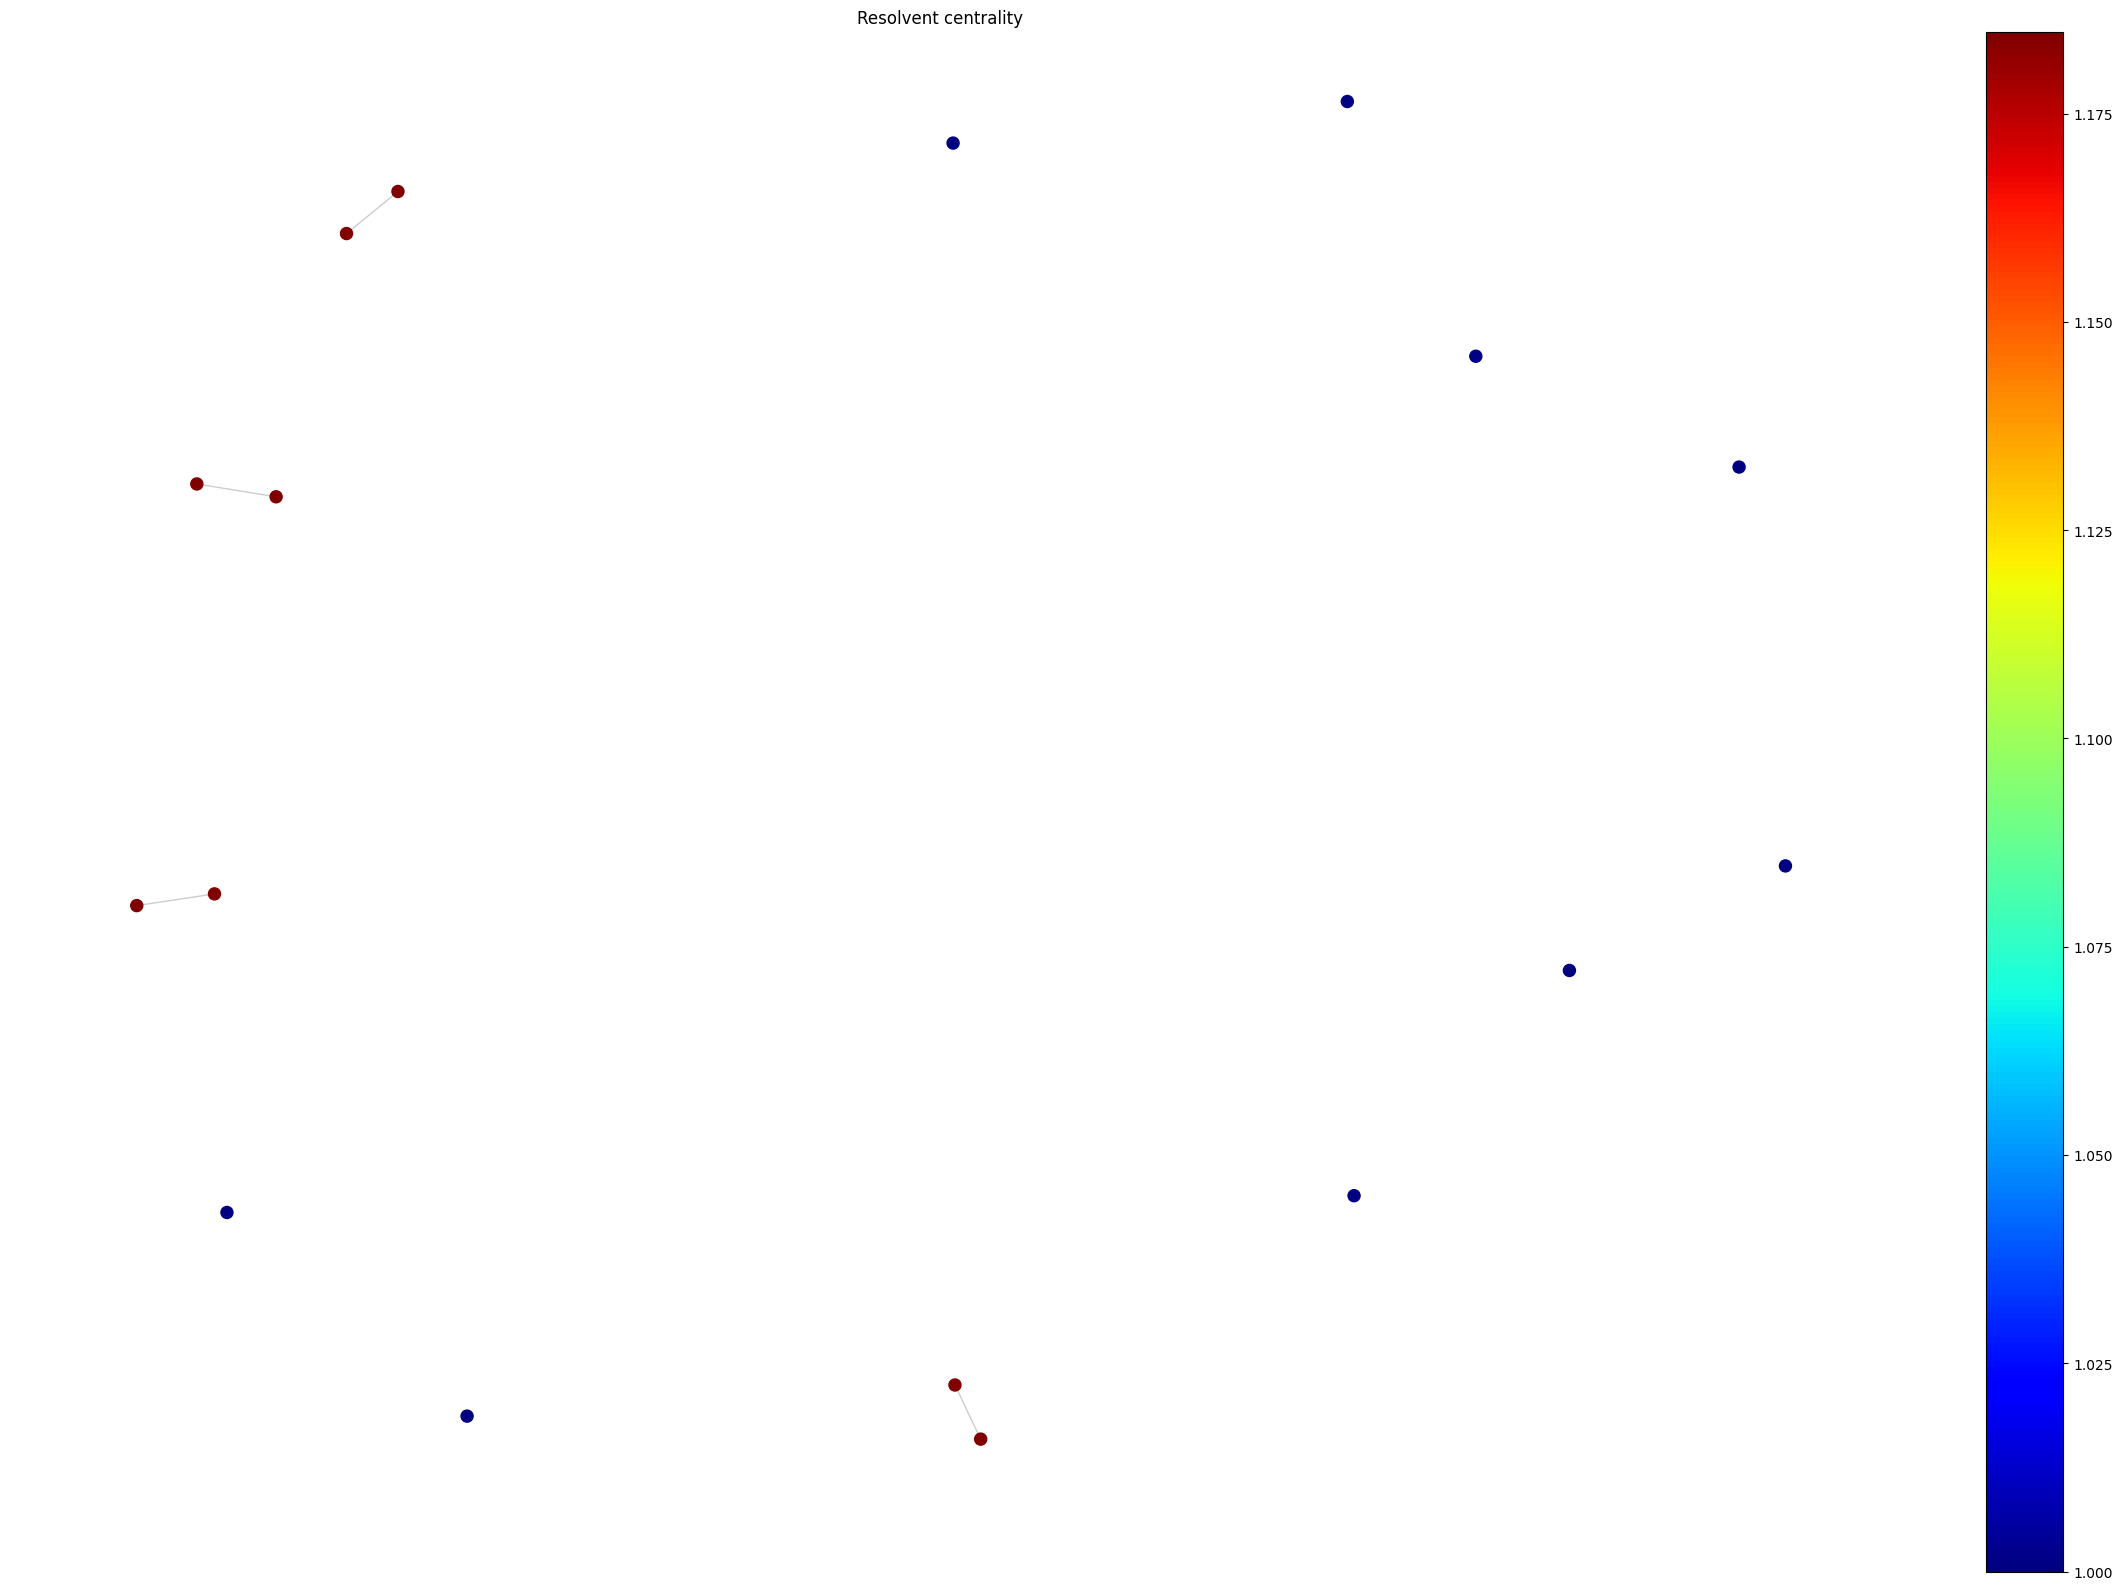

In [ ]:
t1, t2 = 1936, 1960
G_2 = builder.create_temporal_graph(t1, t2, weighted=True)
alpha_2 = 0.395 # alpha given by previous code for this time period!
eigenvector_centrality_2 = get_eigenvector_centrality(G_2)
resolvent_sub_cent_2 = get_res_sub_centrality(G_2, alpha_2)
plot_eig_cent_graph(G_2, eigenvector_centrality_2)
plot_res_cent_graph(G_2, resolvent_sub_cent_2)

Creating graph for period [2001, 2010]: 1418 publications


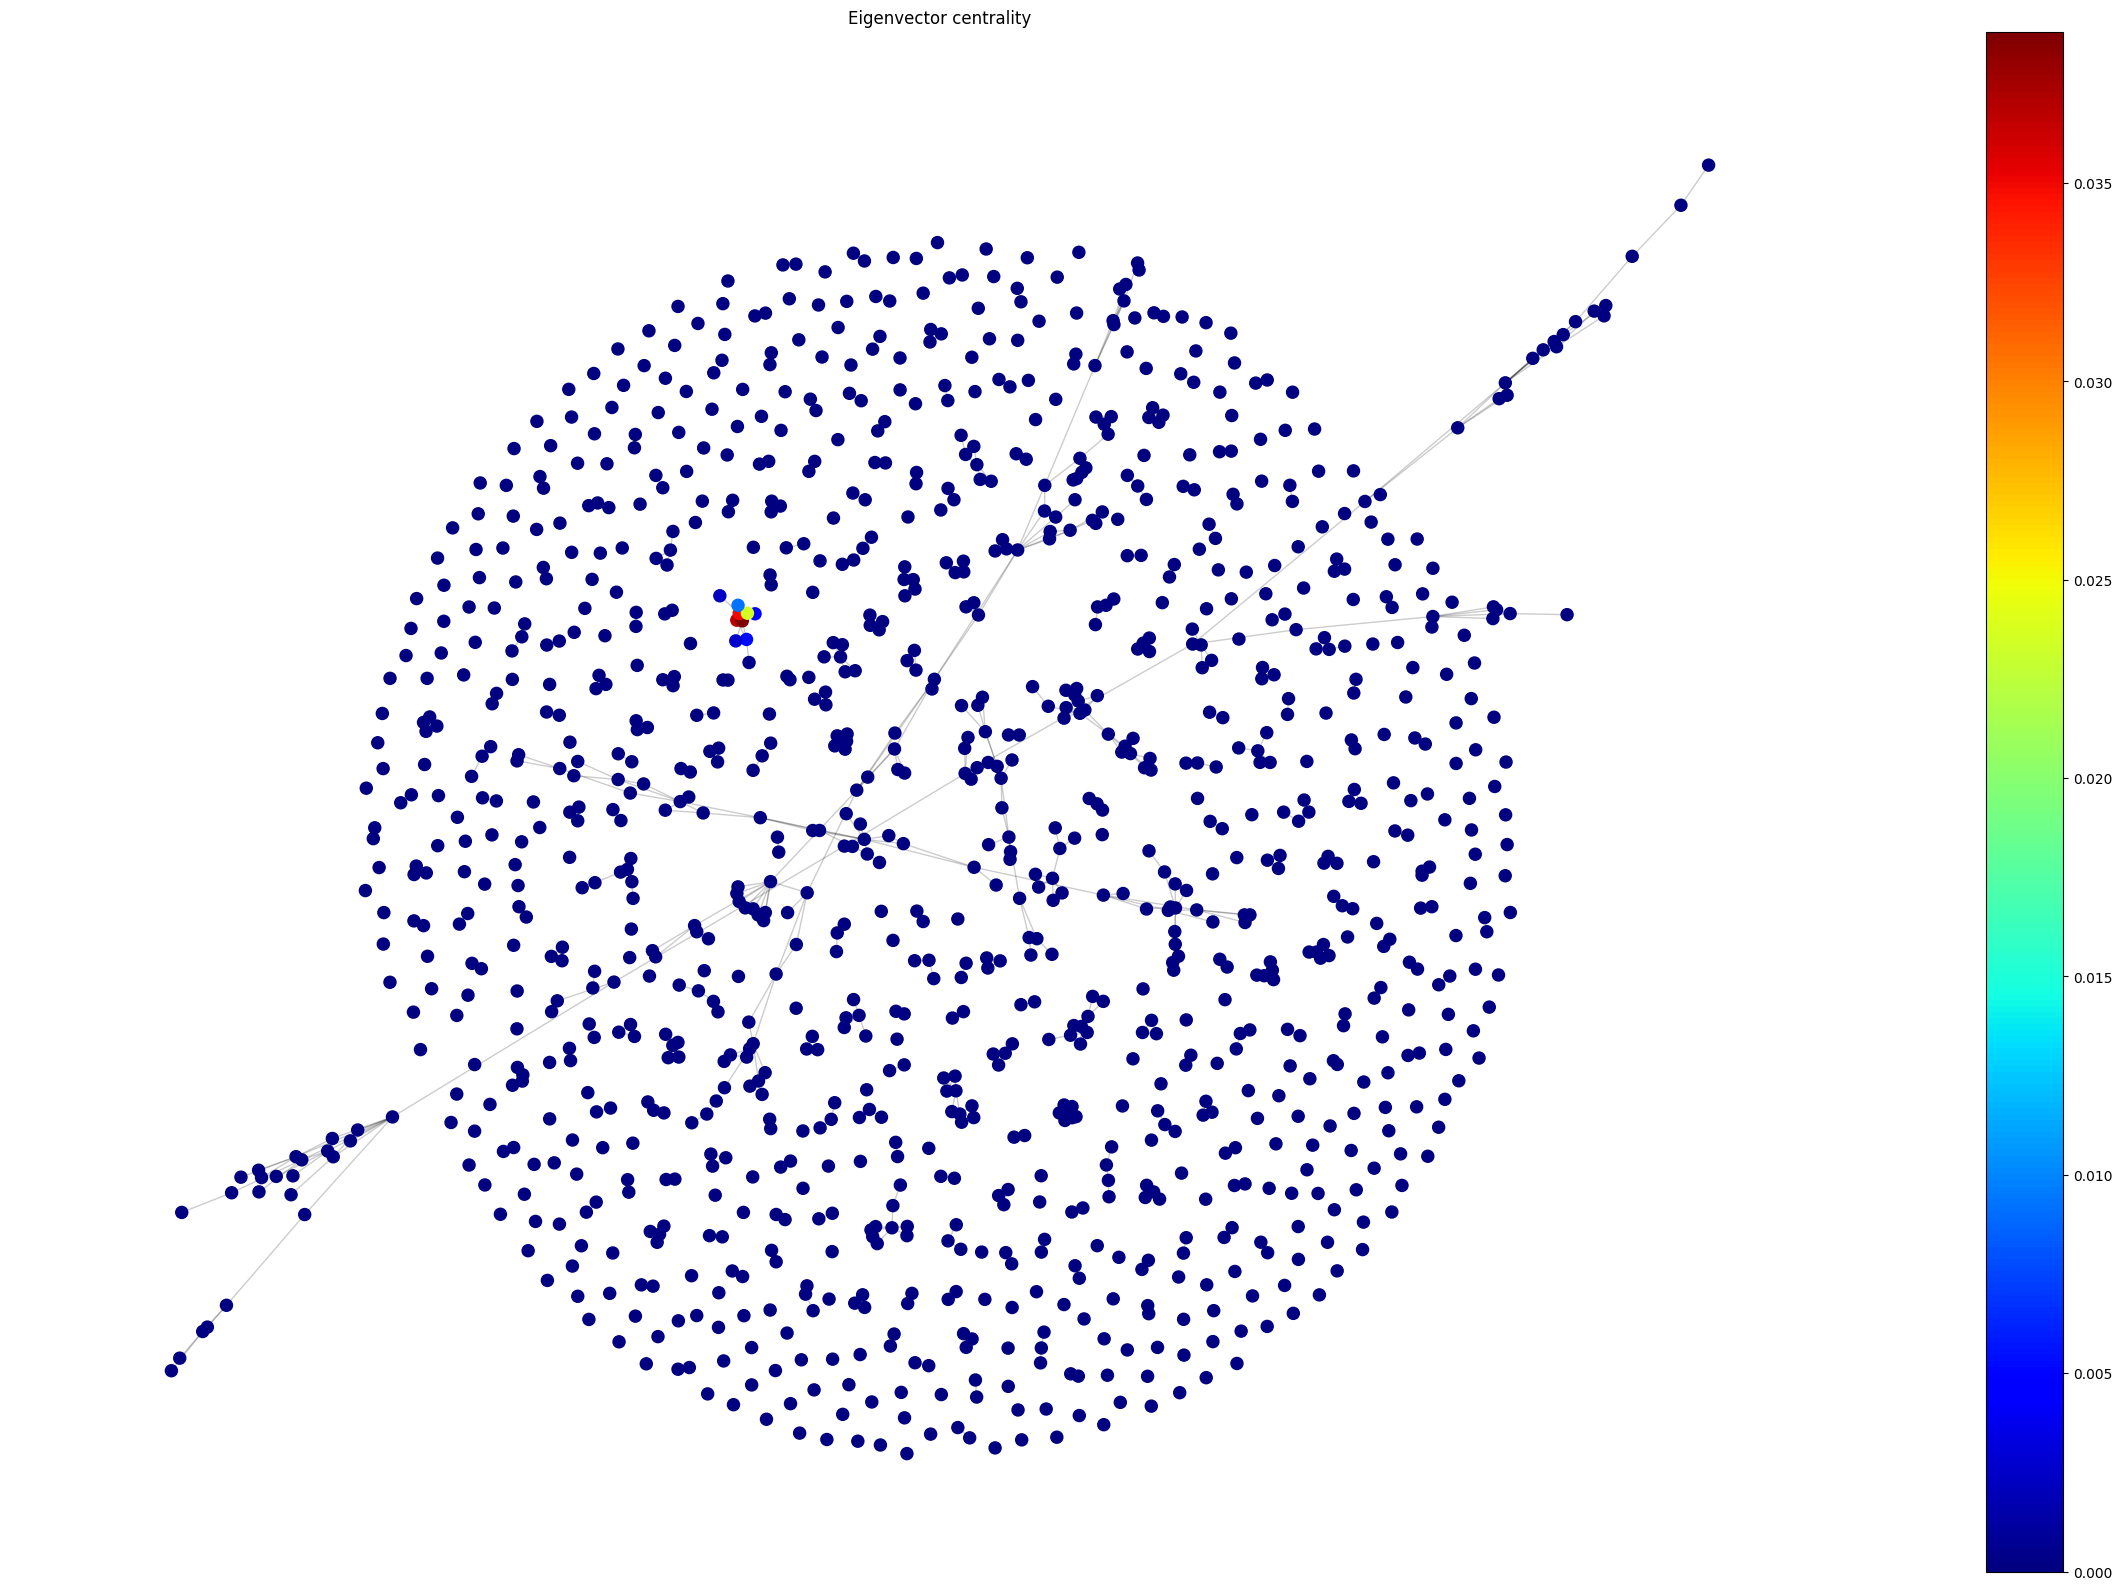

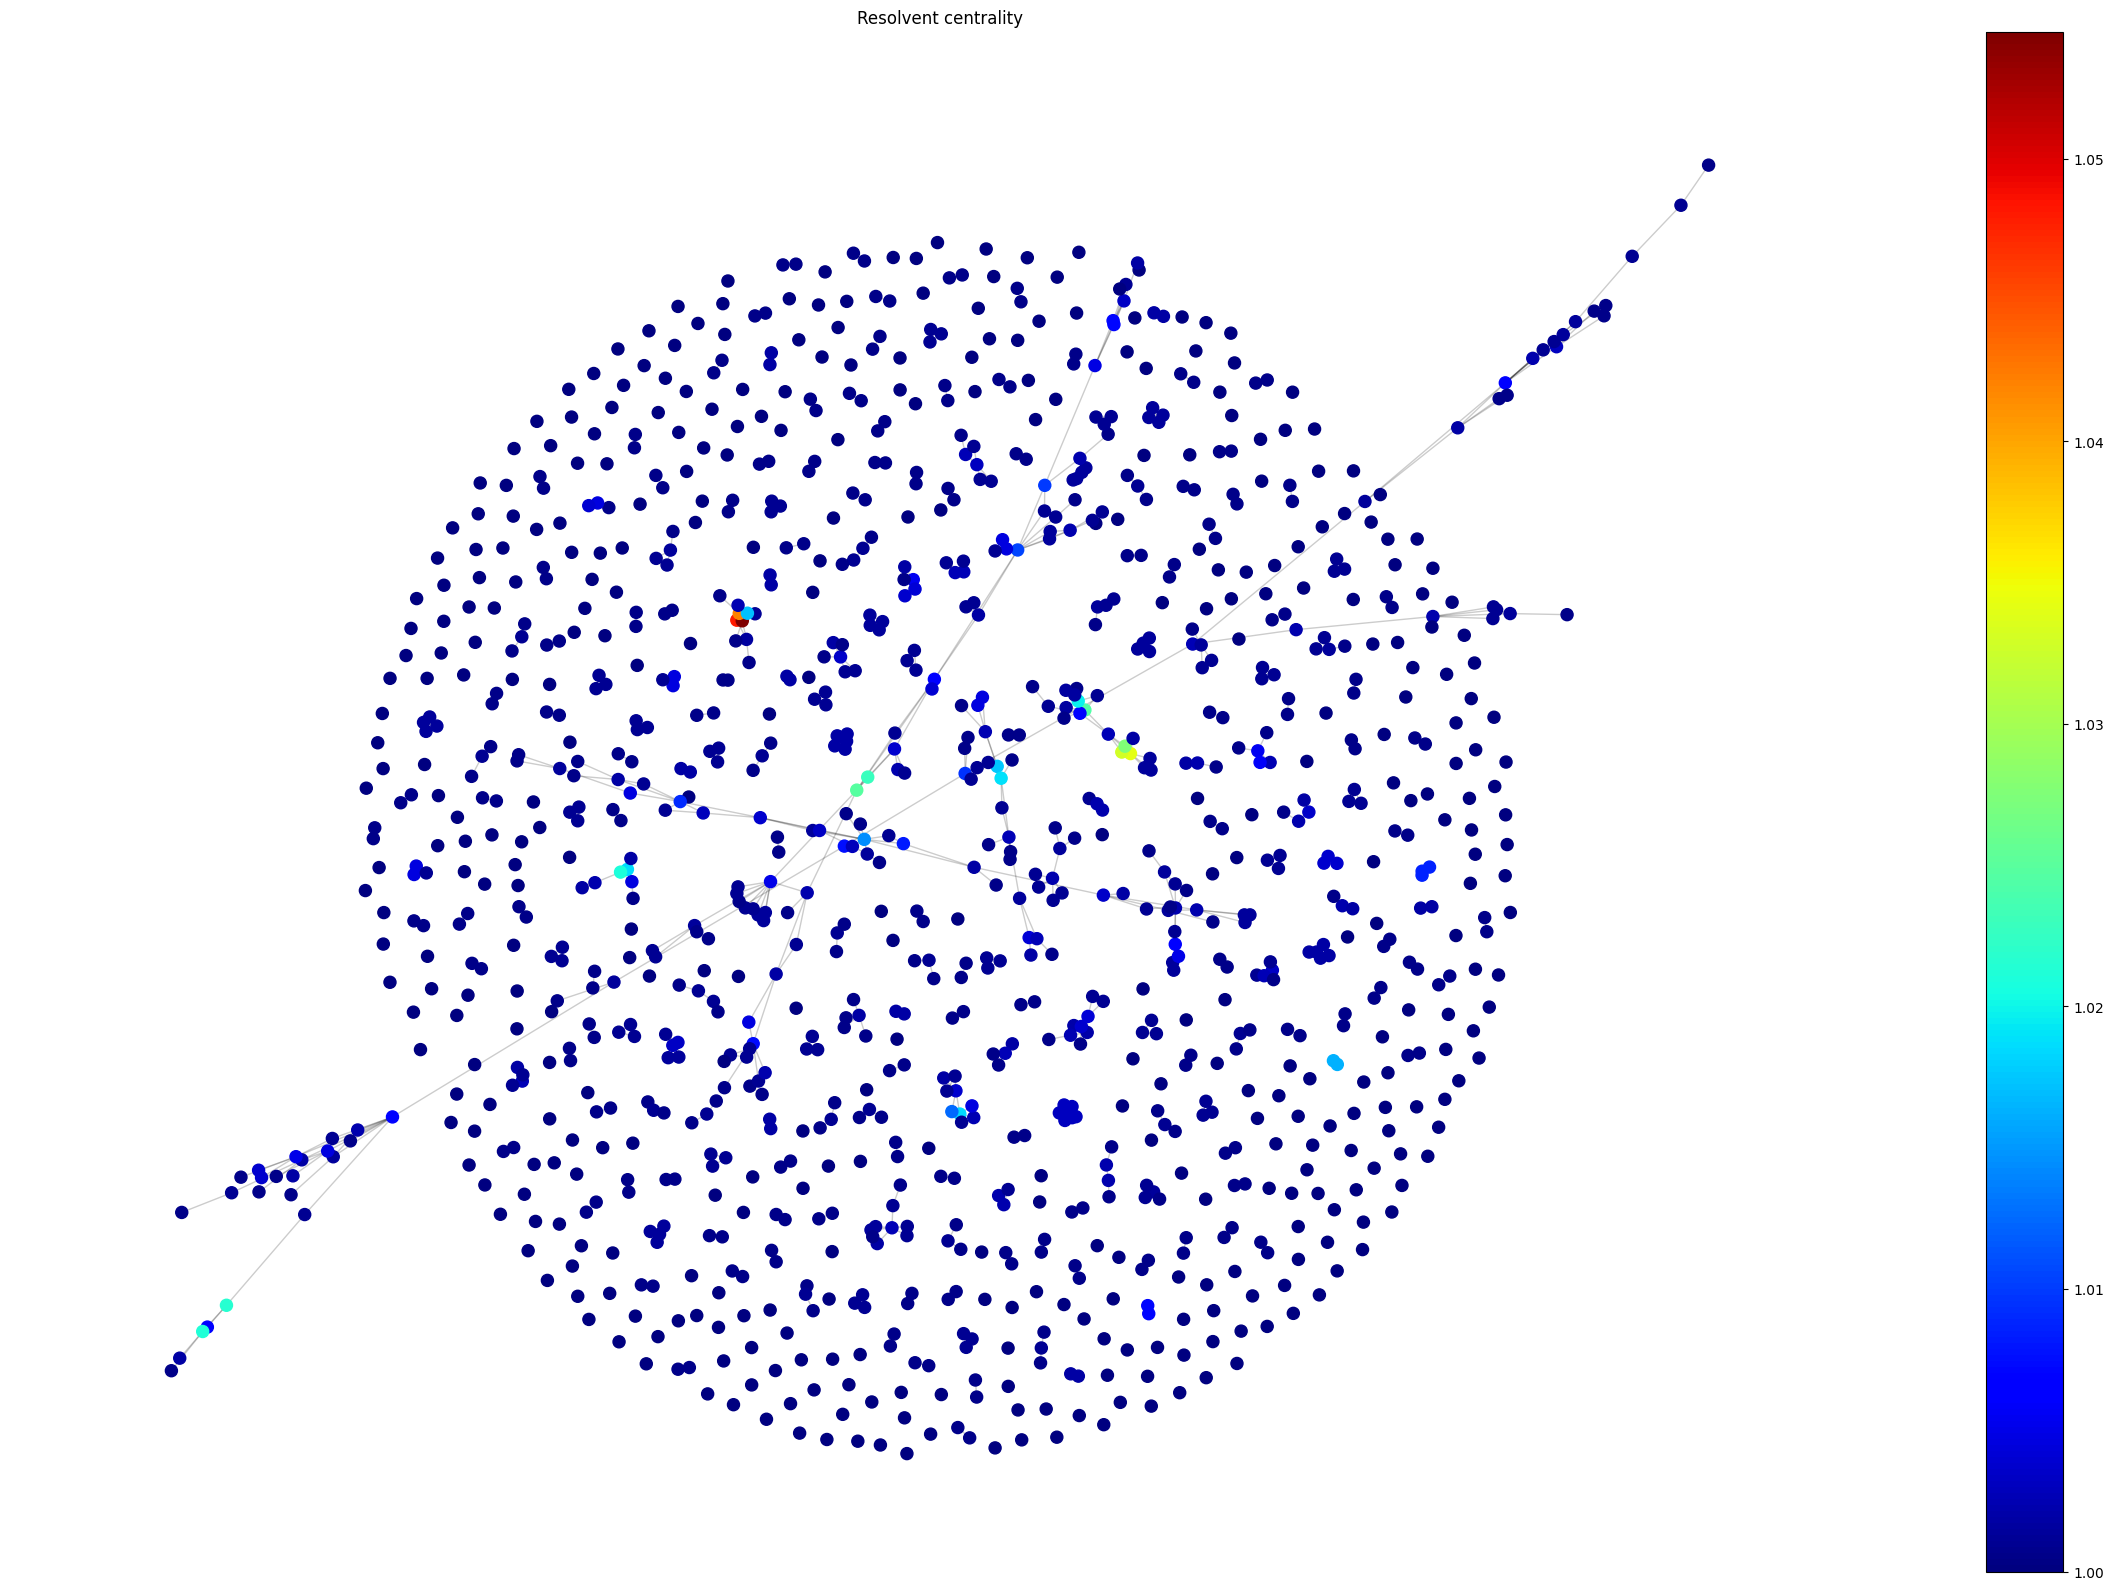

In [ ]:
t1, t2 = 2001, 2010
G_3 = builder.create_temporal_graph(t1, t2, weighted=True)
alpha_3 = 0.0211 # alpha given by previous code for this time period!
eigenvector_centrality_3 = get_eigenvector_centrality(G_3)
resolvent_sub_cent_3 = get_res_sub_centrality(G_3, alpha_3)
plot_eig_cent_graph(G_3, eigenvector_centrality_3)
plot_res_cent_graph(G_3, resolvent_sub_cent_3)

But is it meaningful on disconnected graphs?

In [ ]:
print("Most important authors per time window, using eigenvector centrality:")
for t1, t2 in time_windows:
  G = builder.create_temporal_graph(t1, t2, weighted=True)
  components = list(nx.connected_components(G))
  components = sorted(components, key=len, reverse=True)
  G_lcc = G.subgraph(components[0]).copy() # largest connected component
  print(f"\nPeriod [{t1}, {t2}]:")
  top_authors = top_authors_eig_cent(G_lcc,5)
  print(f"Top 5 authors for period {t1} - {t2}: {top_authors}")

Most important authors per time window, using eigenvector centrality:
Creating graph for period [1936, 1960]: 30 publications

Period [1936, 1960]:
Top 5 authors for period 1936 - 1960: {'J W T Youngs': 0.35355339059327373, 'Patrick Shanahan': 0.3535533905932736}
Creating graph for period [1961, 1980]: 3146 publications

Period [1961, 1980]:
Top 5 authors for period 1961 - 1980: {'E B Curtis': 0.09891210065827526, 'Martin Bendersky': 0.0989121006582752, 'Haynes Miller': 0.0845969555813106, 'Victor Snaith': 0.04372329293648804, 'Luke Hodgkin': 0.022790934494261297}
Creating graph for period [1981, 2000]: 5730 publications

Period [1981, 2000]:
Top 5 authors for period 1981 - 2000: {'Donald M Davis': 0.02861482571161639, 'Mark Mahowald': 0.028565691489106763, 'Sam Gitler': 0.010598369851073076, 'Martin Bendersky': 0.009198256967207314, 'John Klippenstein': 0.006563430500079607}
Creating graph for period [2001, 2010]: 2836 publications

Period [2001, 2010]:
Top 5 authors for period 2001 -

In [ ]:
print("Most important authors per time window, using resolvent subgraph centrality:")
for t1, t2 in time_windows:
  G = builder.create_temporal_graph(t1, t2, weighted=True)
  components = list(nx.connected_components(G))
  components = sorted(components, key=len, reverse=True)
  G_lcc = G.subgraph(components[0]).copy()
  # Calculate inverse of largest eigenvalue to determine alpha range
  largest_eigenvalue, inv_eig = get_largest_egvalue(G_lcc)
  alpha = np.random.uniform(0, inv_eig)
  print(f"\nPeriod [{t1}, {t2}]:")
  print(f"  - Alpha: {alpha}")
  top_authors = top_authors_res_sub_cent(G_lcc, alpha, 5)
  print(f"Top 5 authors for period {t1} - {t2}: {top_authors}")

Most important authors per time window, using resolvent subgraph centrality:
Creating graph for period [1936, 1960]: 30 publications

Period [1936, 1960]:
  - Alpha: 0.46140848841949994
Top 5 authors for period 1936 - 1960: {'J W T Youngs': 6.738143670277689, 'Patrick Shanahan': 6.738143670277689}
Creating graph for period [1961, 1980]: 3146 publications

Period [1961, 1980]:
  - Alpha: 0.09097298597257046
Top 5 authors for period 1961 - 1980: {'Martin Bendersky': 1.2477183448857156, 'E B Curtis': 1.2477183448857156, 'Ib Madsen': 1.1792680090129868, 'Victor P Snaith': 1.1791840567575913, 'Mark E Mahowald': 1.1766492603533099}
Creating graph for period [1981, 2000]: 5730 publications

Period [1981, 2000]:
  - Alpha: 0.012354322231668146
Top 5 authors for period 1981 - 2000: {'Mark Mahowald': 1.0567236693049062, 'Donald M Davis': 1.0562245992987394, 'J Peter May': 1.0260457607089155, 'Douglas C Ravenel': 1.0239804738221803, 'Vladimir Vershinin': 1.0219643424493532}
Creating graph for per

Creating graph for period [2021, 2023]: 1196 publications


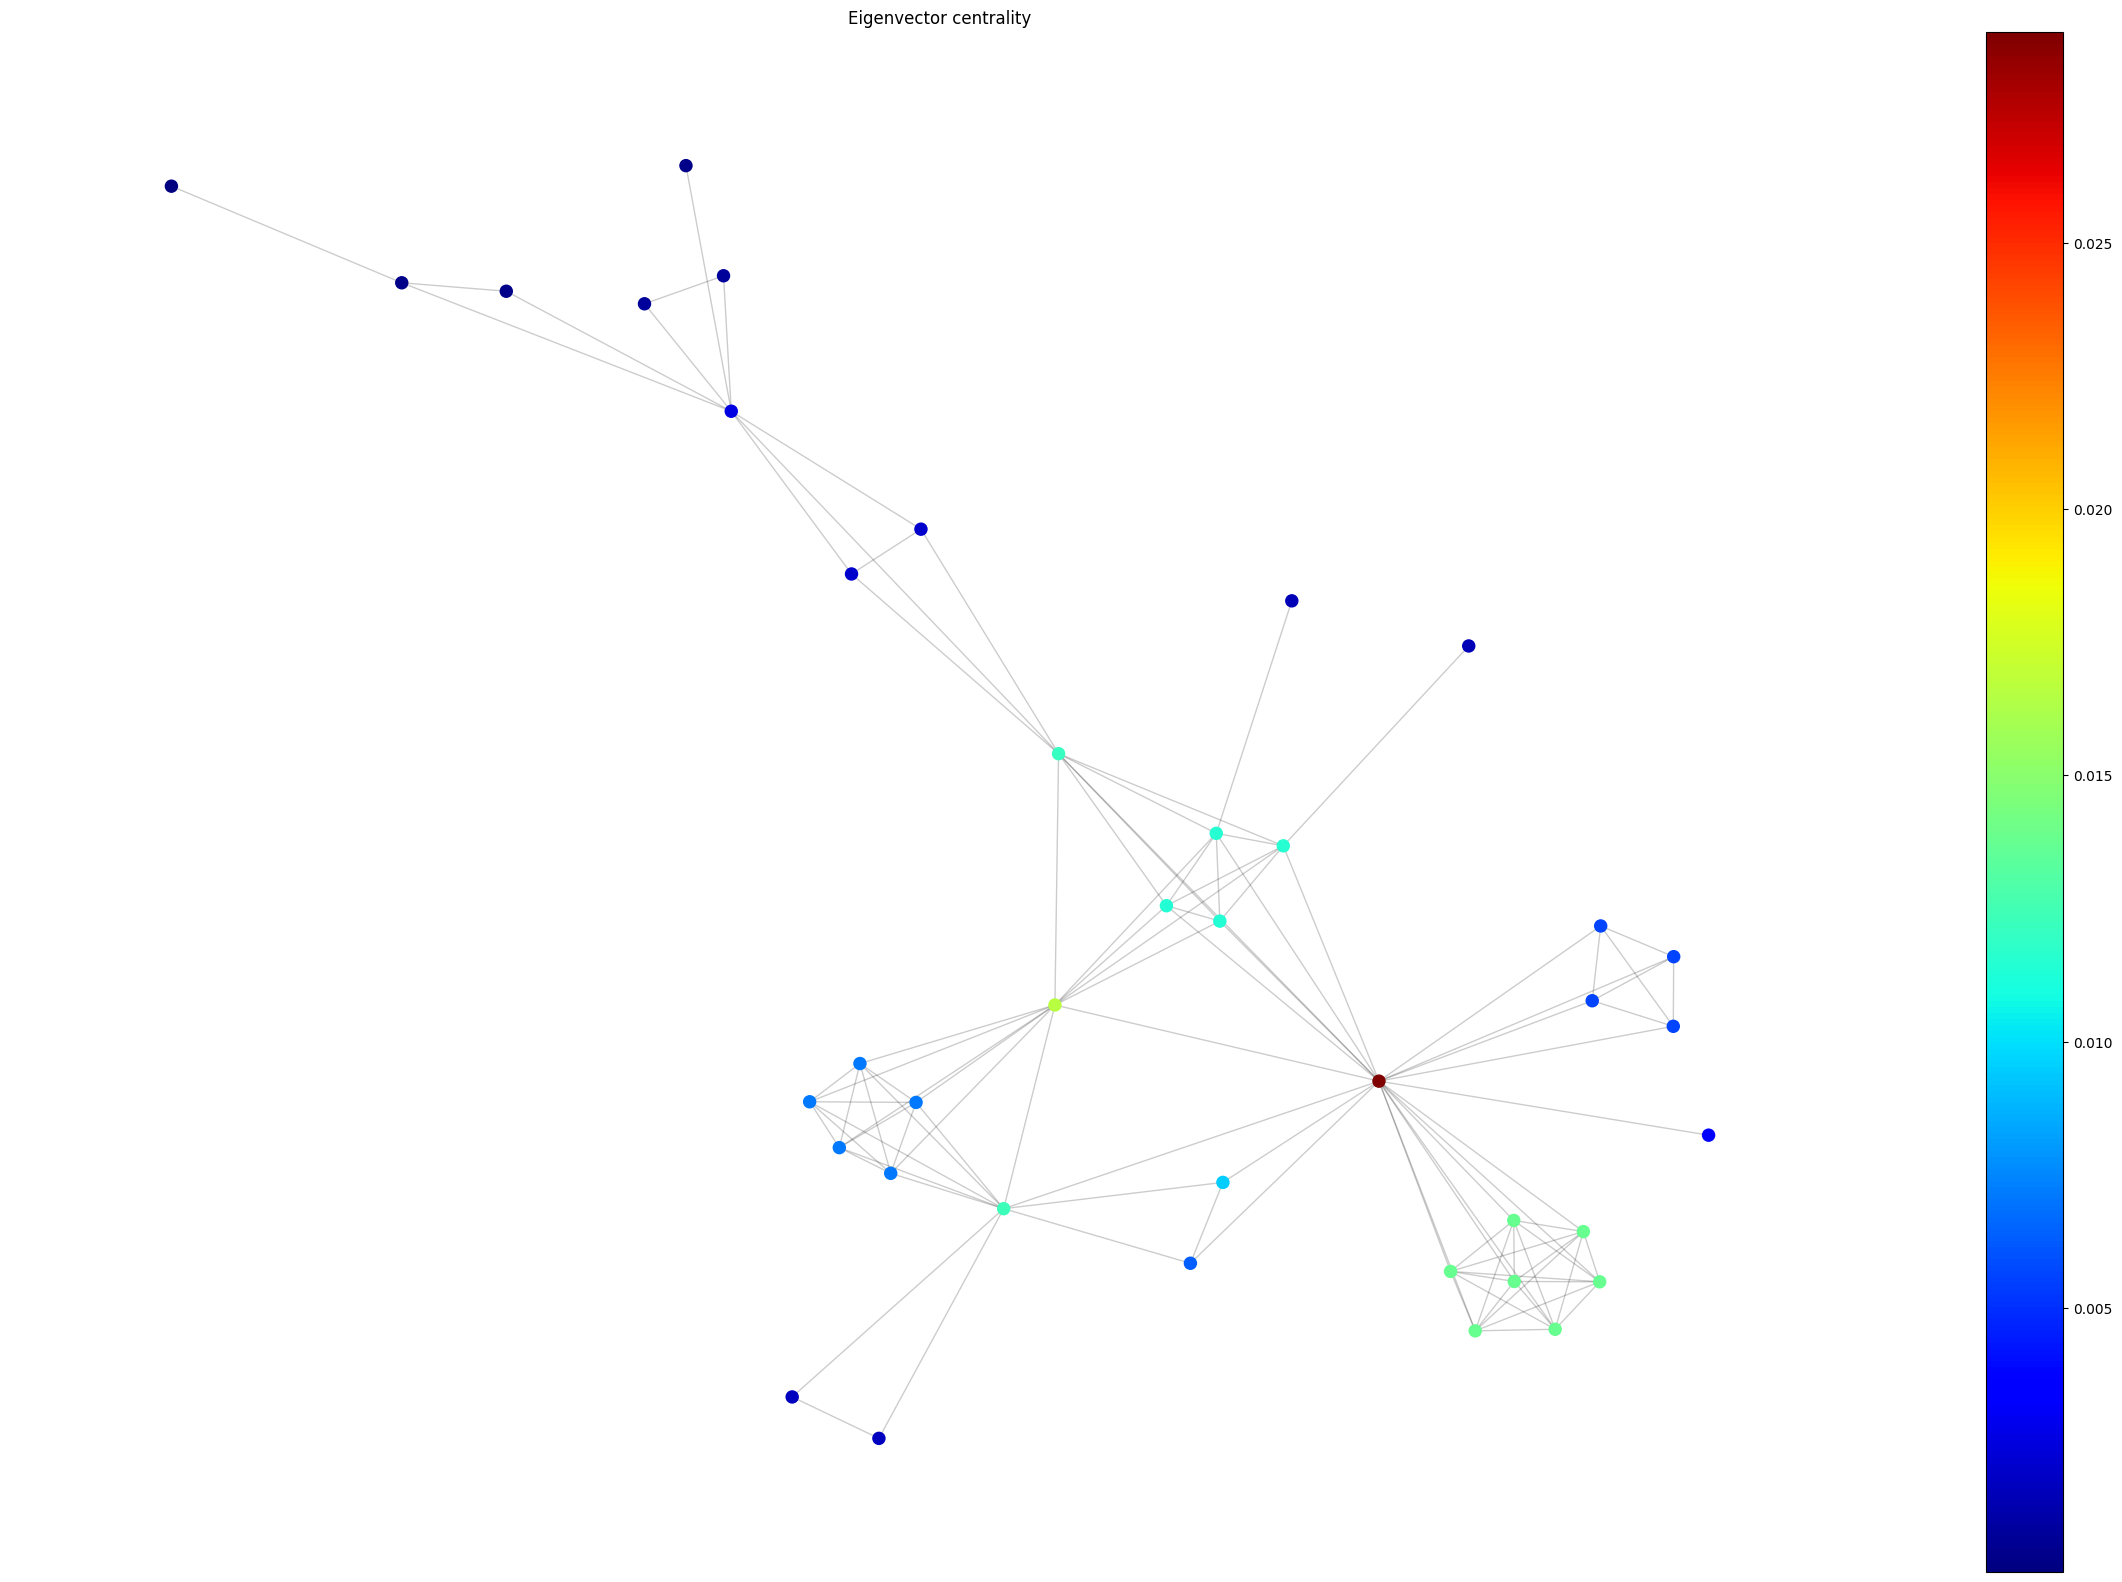

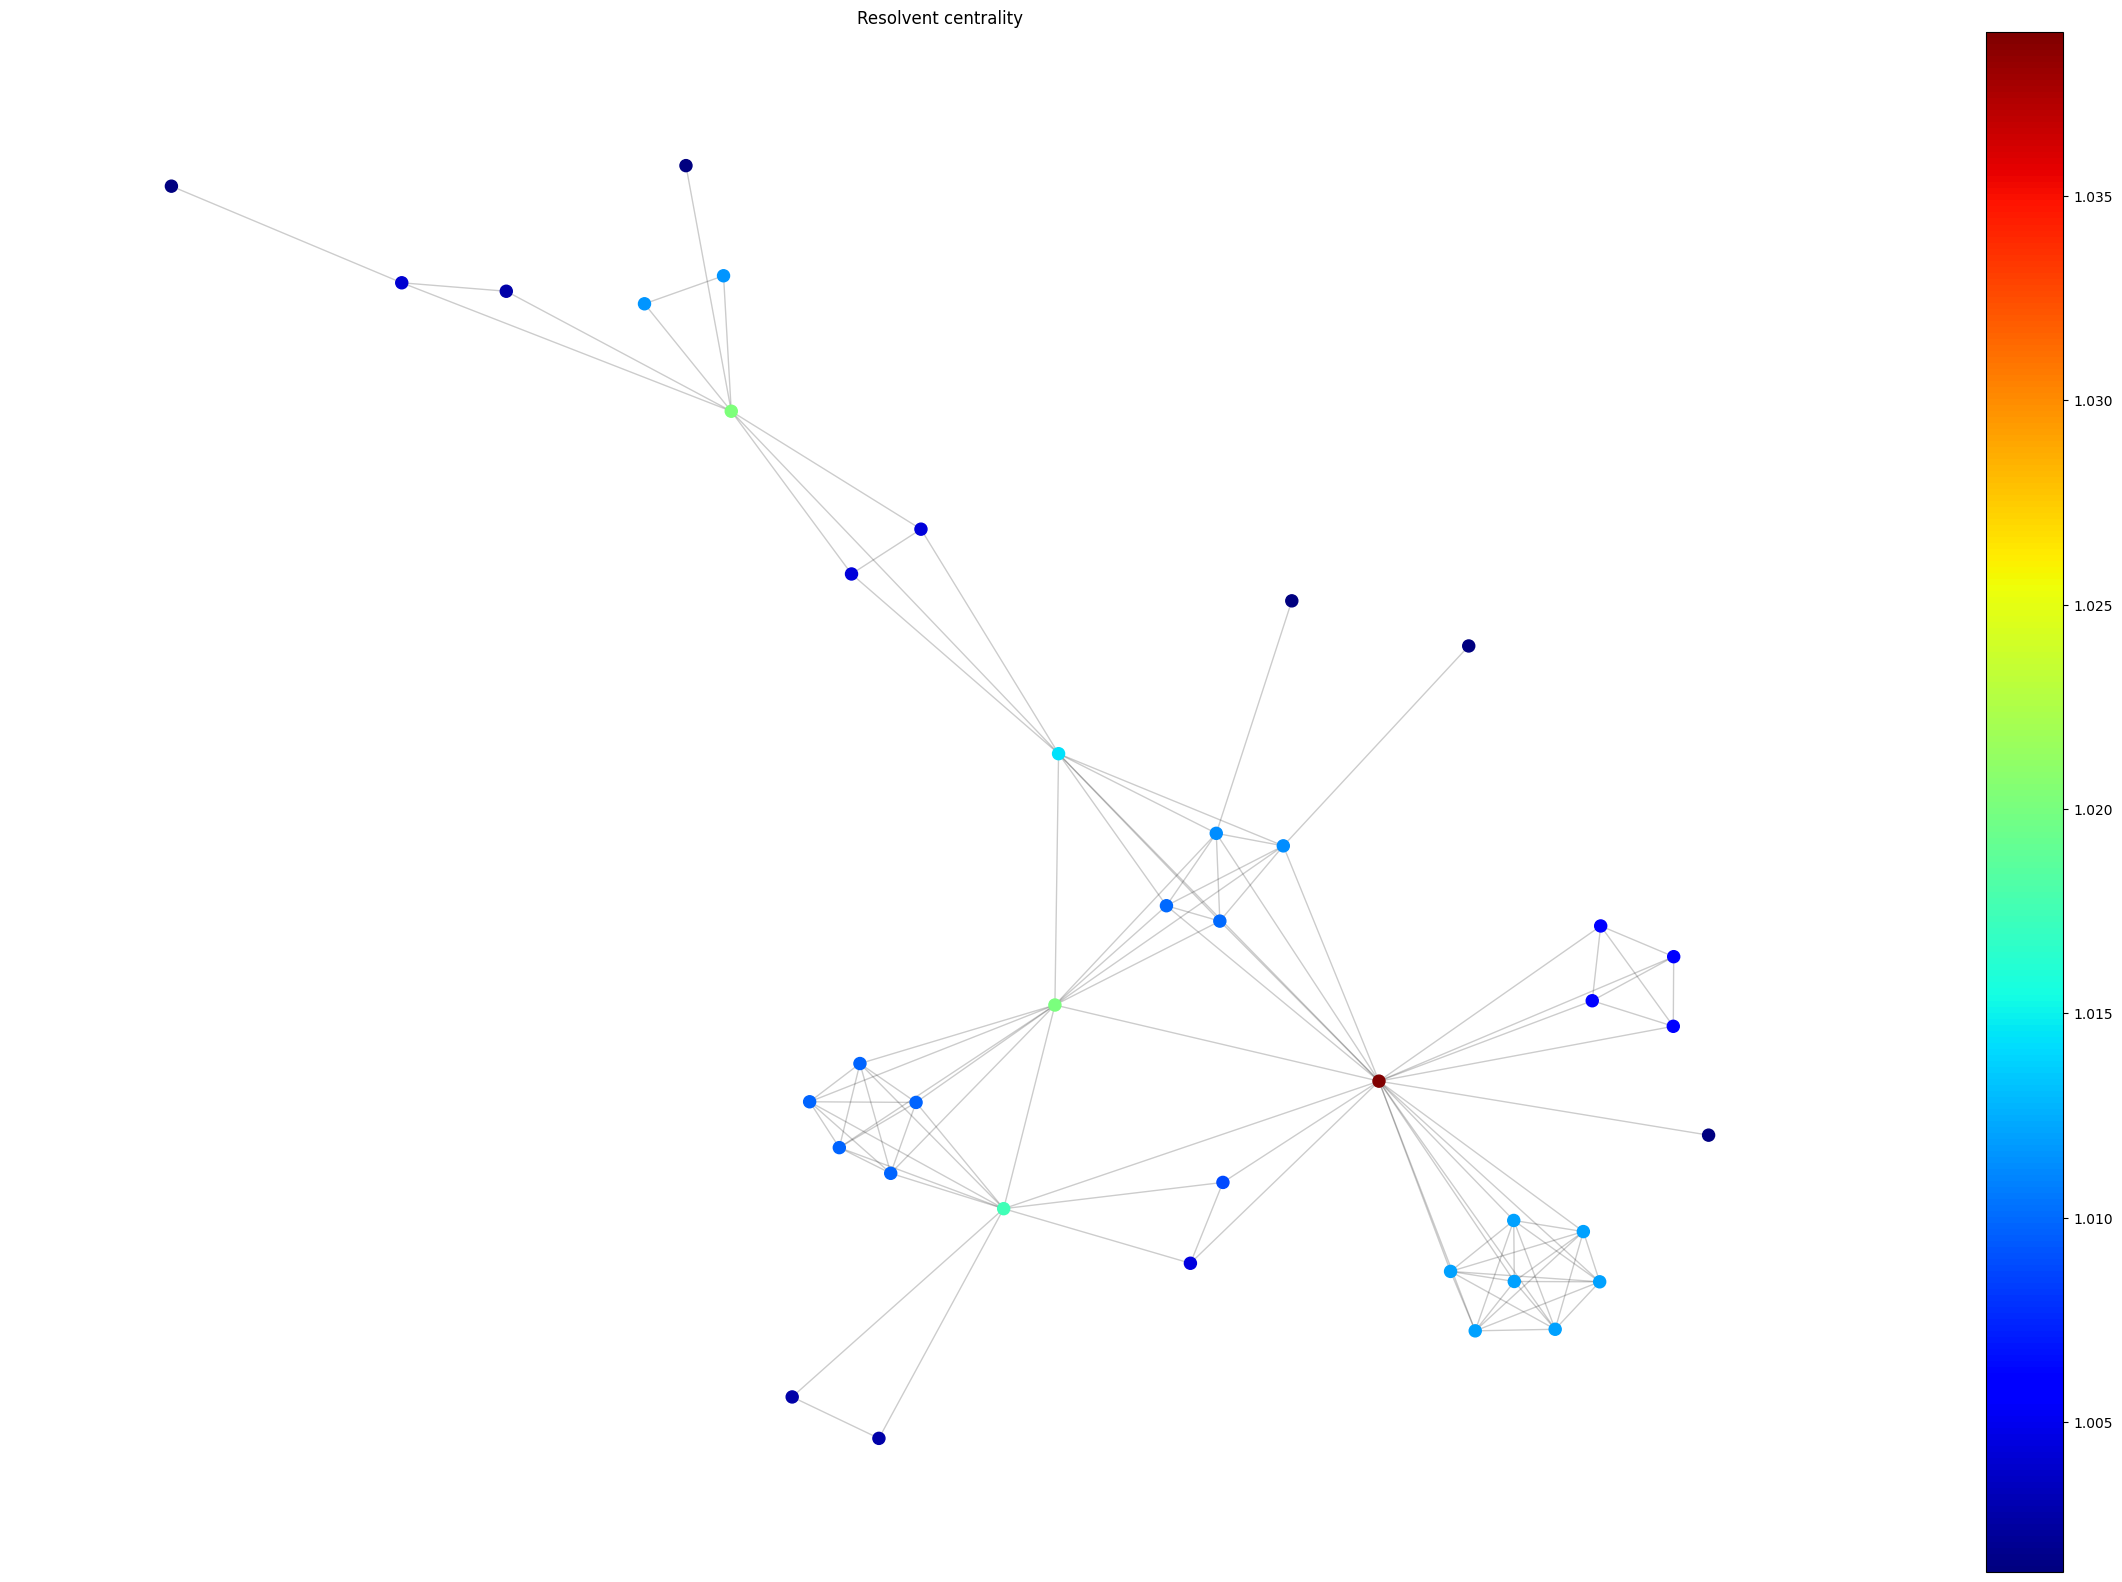

In [ ]:
t1, t2 = 2021, 2023
G_1 = builder.create_temporal_graph(t1, t2, weighted=True)
components = list(nx.connected_components(G_1))
components = sorted(components, key=len, reverse=True)
G_lcc_1 = G_1.subgraph(components[0]).copy()
alpha_1 = 0.0182 # alpha given by previous code for this time period
eigenvector_centrality_1 = get_eigenvector_centrality(G_lcc_1)
resolvent_sub_cent_1 = get_res_sub_centrality(G_lcc_1, alpha_1)
plot_eig_cent_graph(G_lcc_1, eigenvector_centrality_1 )
plot_res_cent_graph(G_lcc_1, resolvent_sub_cent_1)

Creating graph for period [1936, 1960]: 30 publications


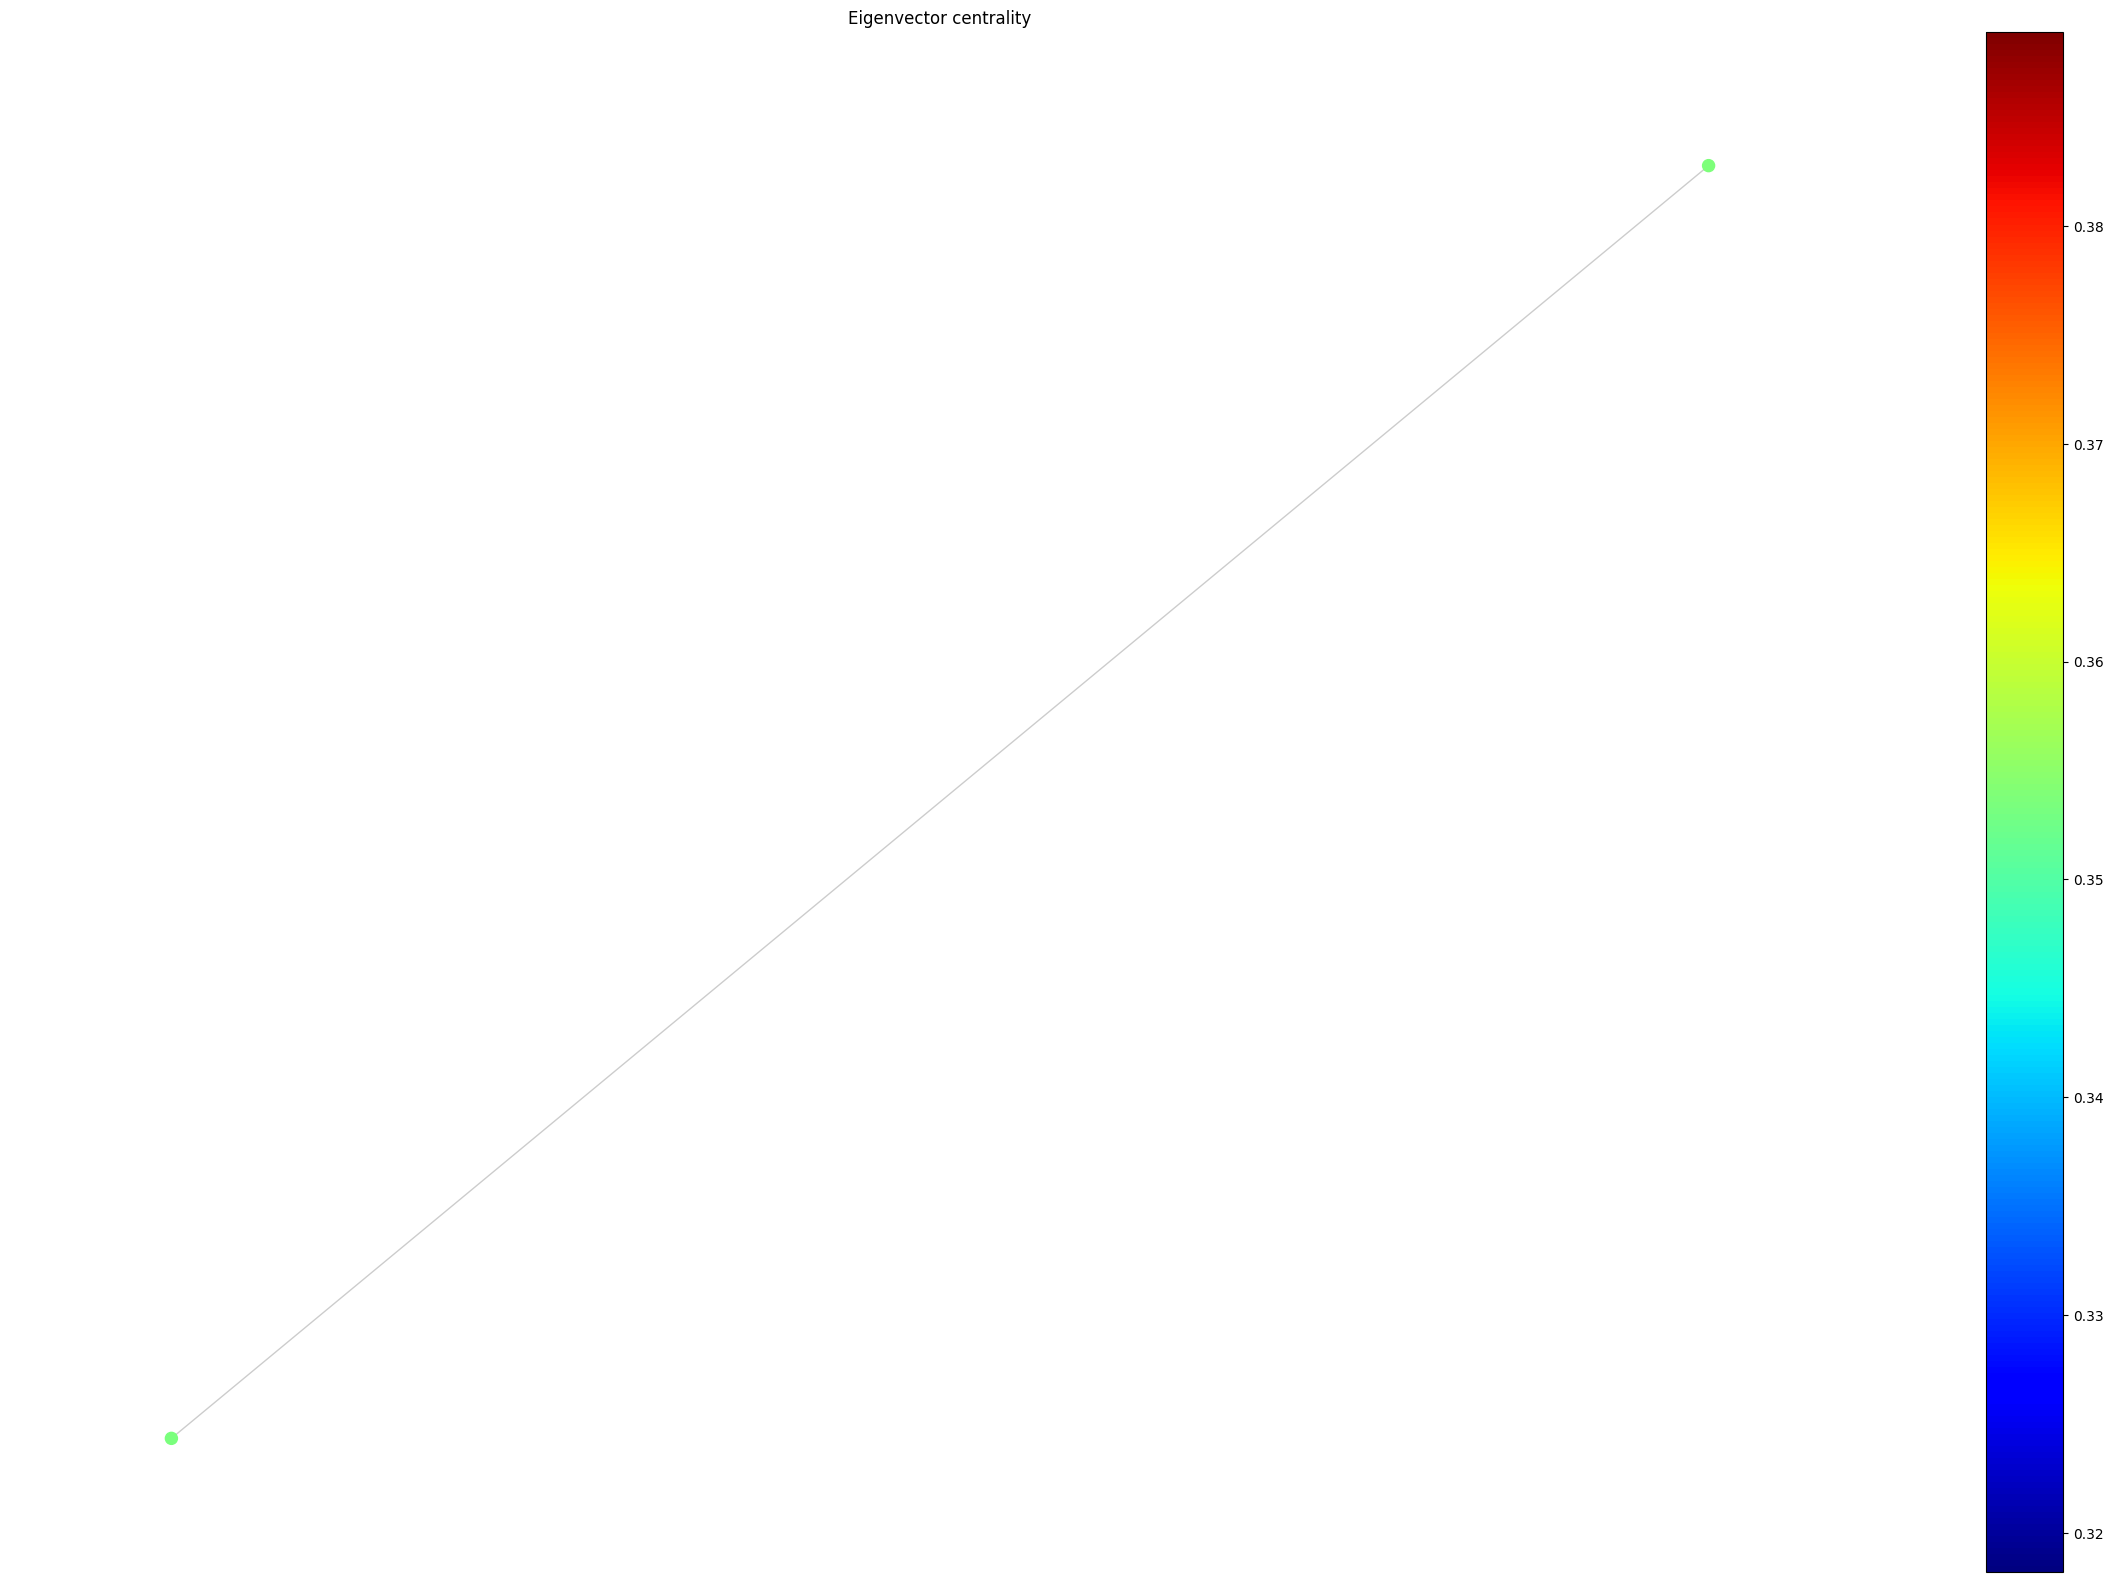

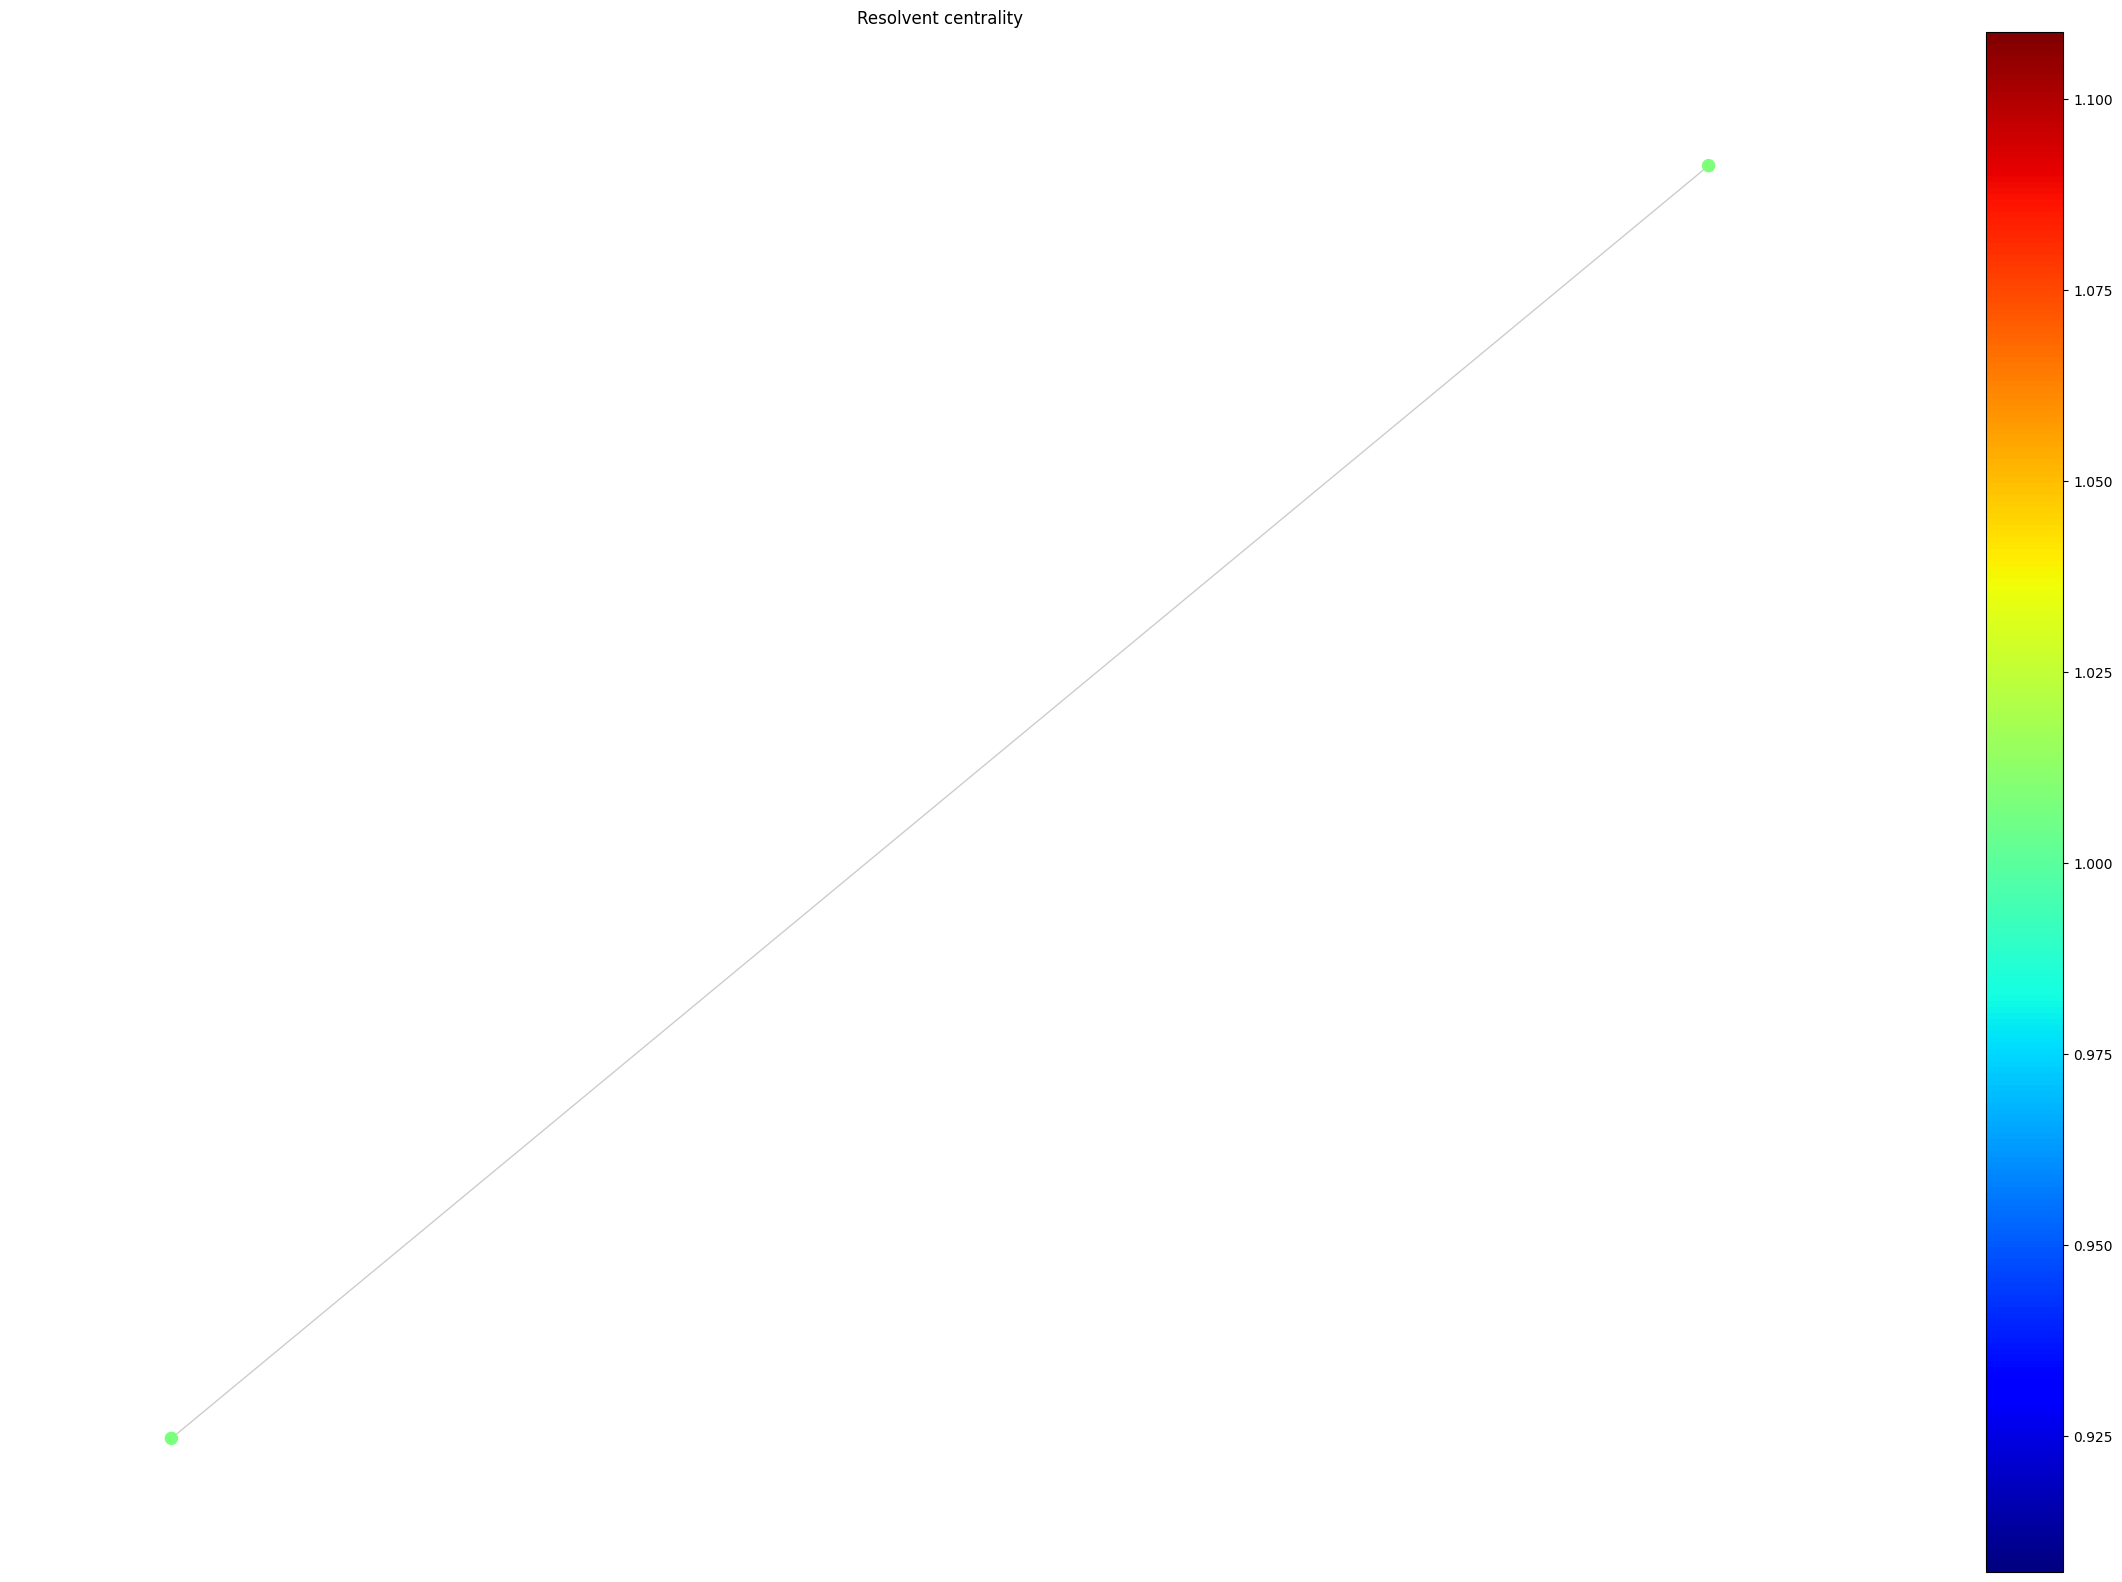

In [ ]:
t1, t2 = 1936, 1960
G_2 = builder.create_temporal_graph(t1, t2, weighted=True)
components = list(nx.connected_components(G_2))
components = sorted(components, key=len, reverse=True)
G_lcc_2 = G_2.subgraph(components[0]).copy()
alpha_2 = 0.0445 # alpha given by previous code for this time period
eigenvector_centrality_2 = get_eigenvector_centrality(G_lcc_2)
resolvent_sub_cent_2 = get_res_sub_centrality(G_lcc_2, alpha_2)
plot_eig_cent_graph(G_lcc_2, eigenvector_centrality_2)
plot_res_cent_graph(G_lcc_2, resolvent_sub_cent_2)

Creating graph for period [2001, 2010]: 2836 publications


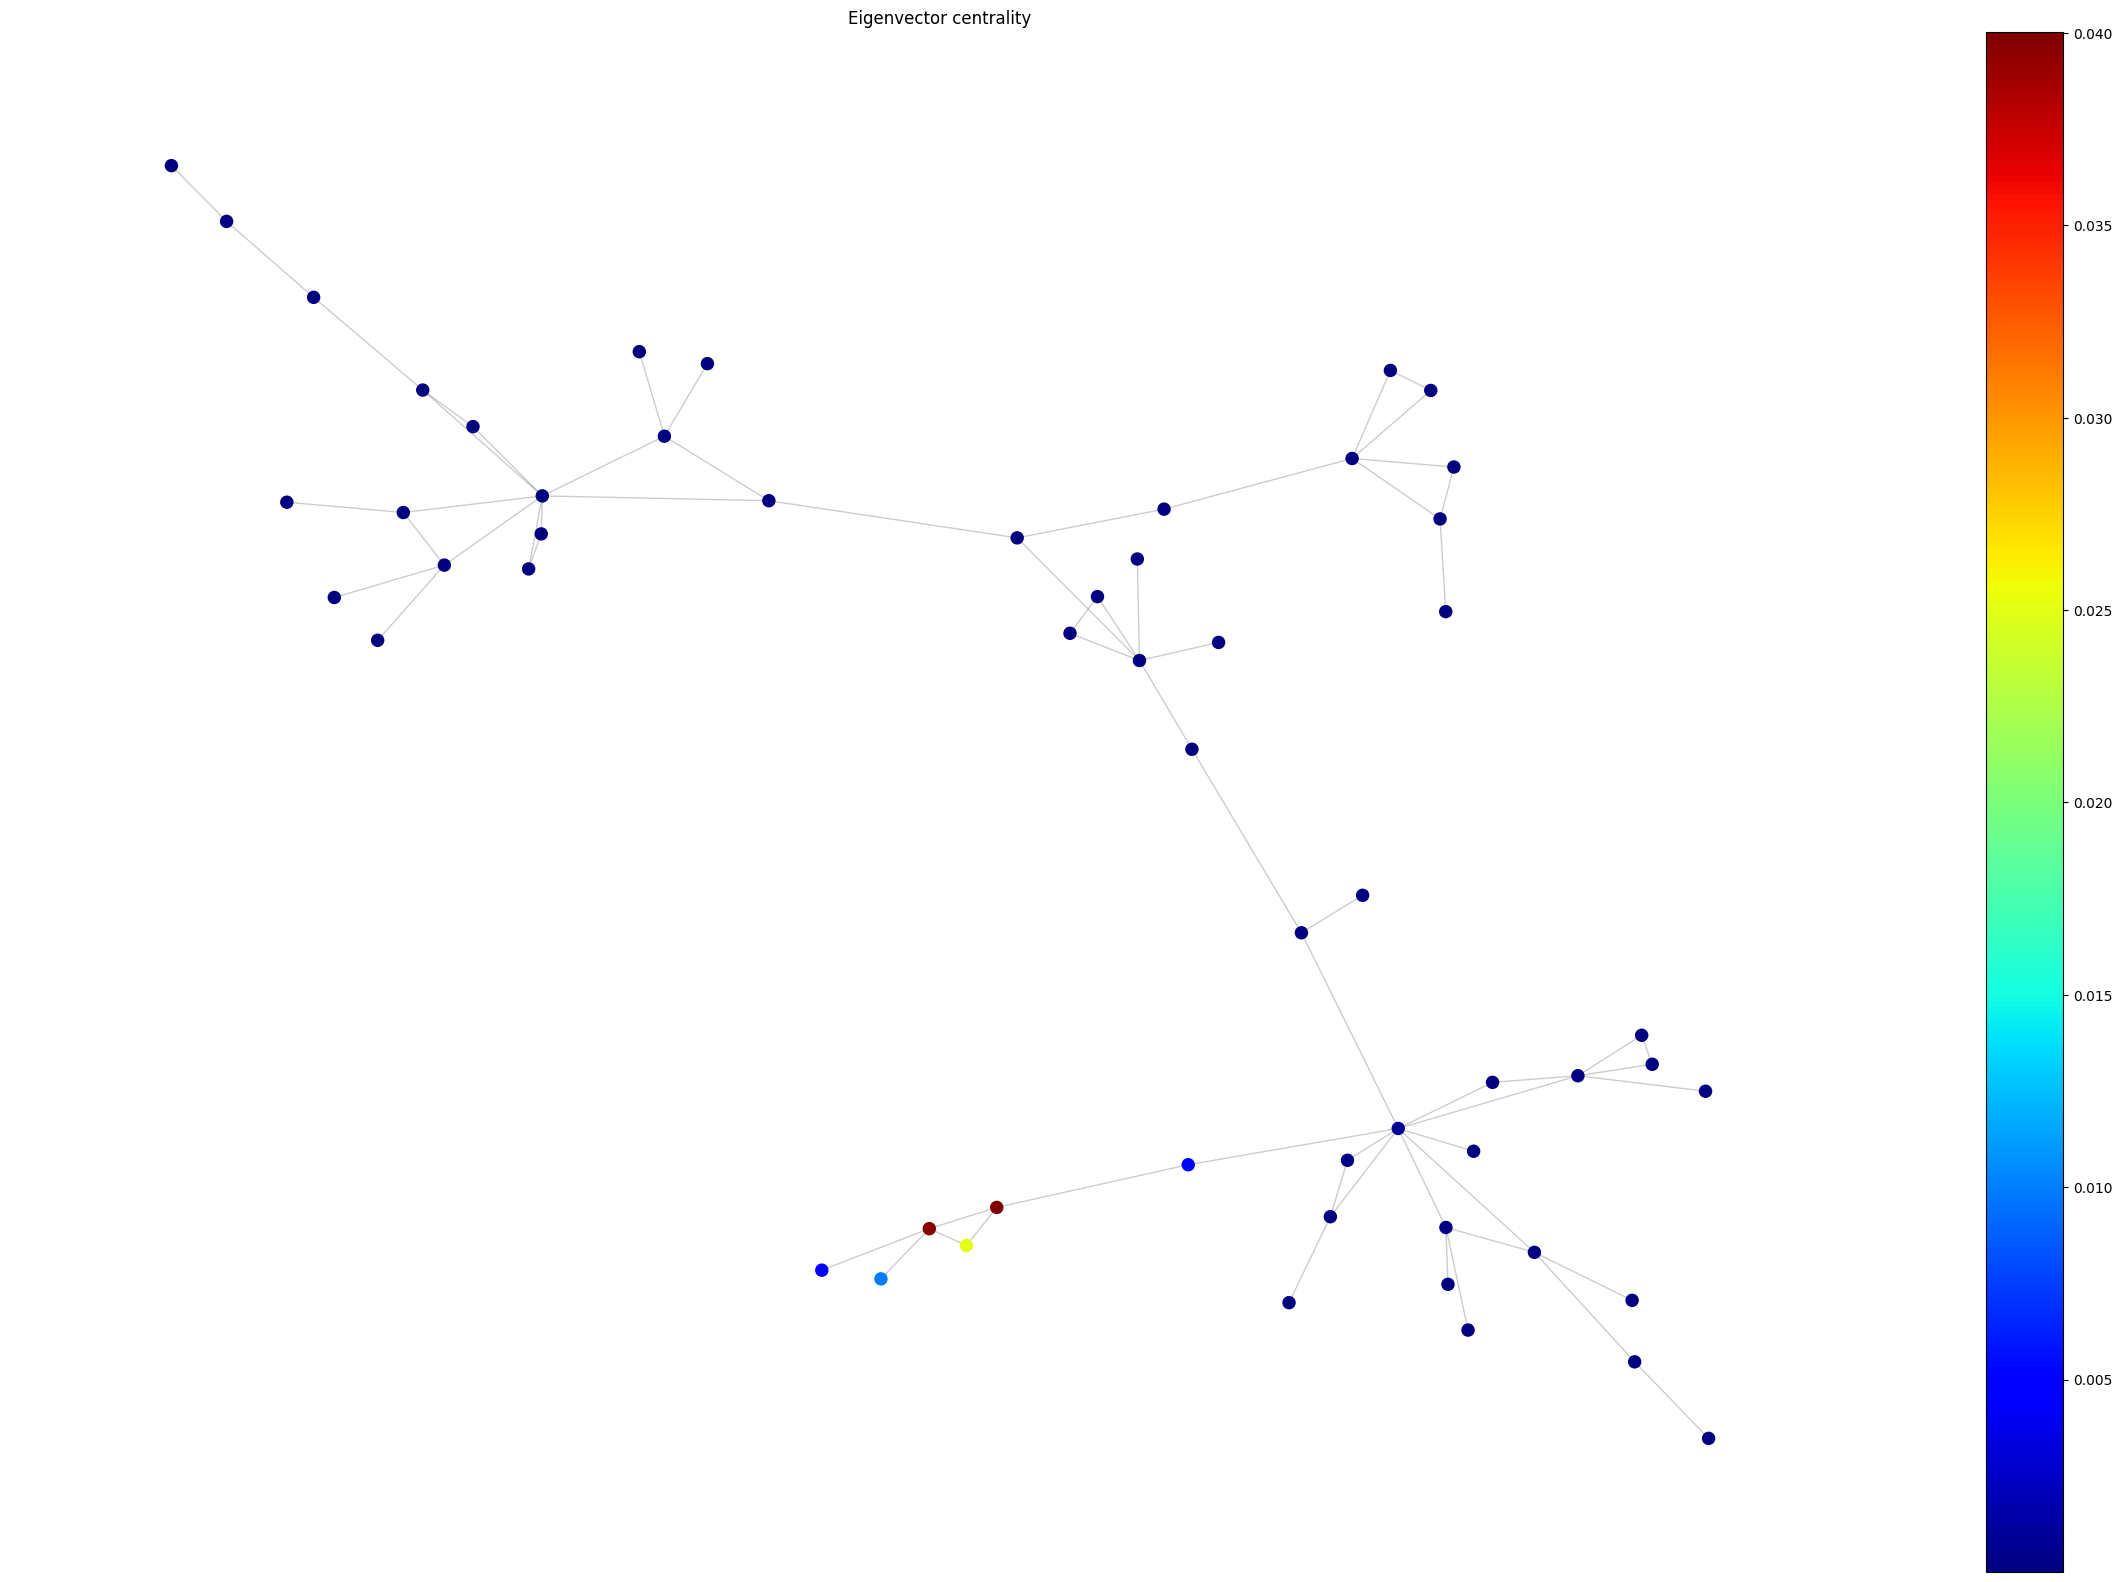

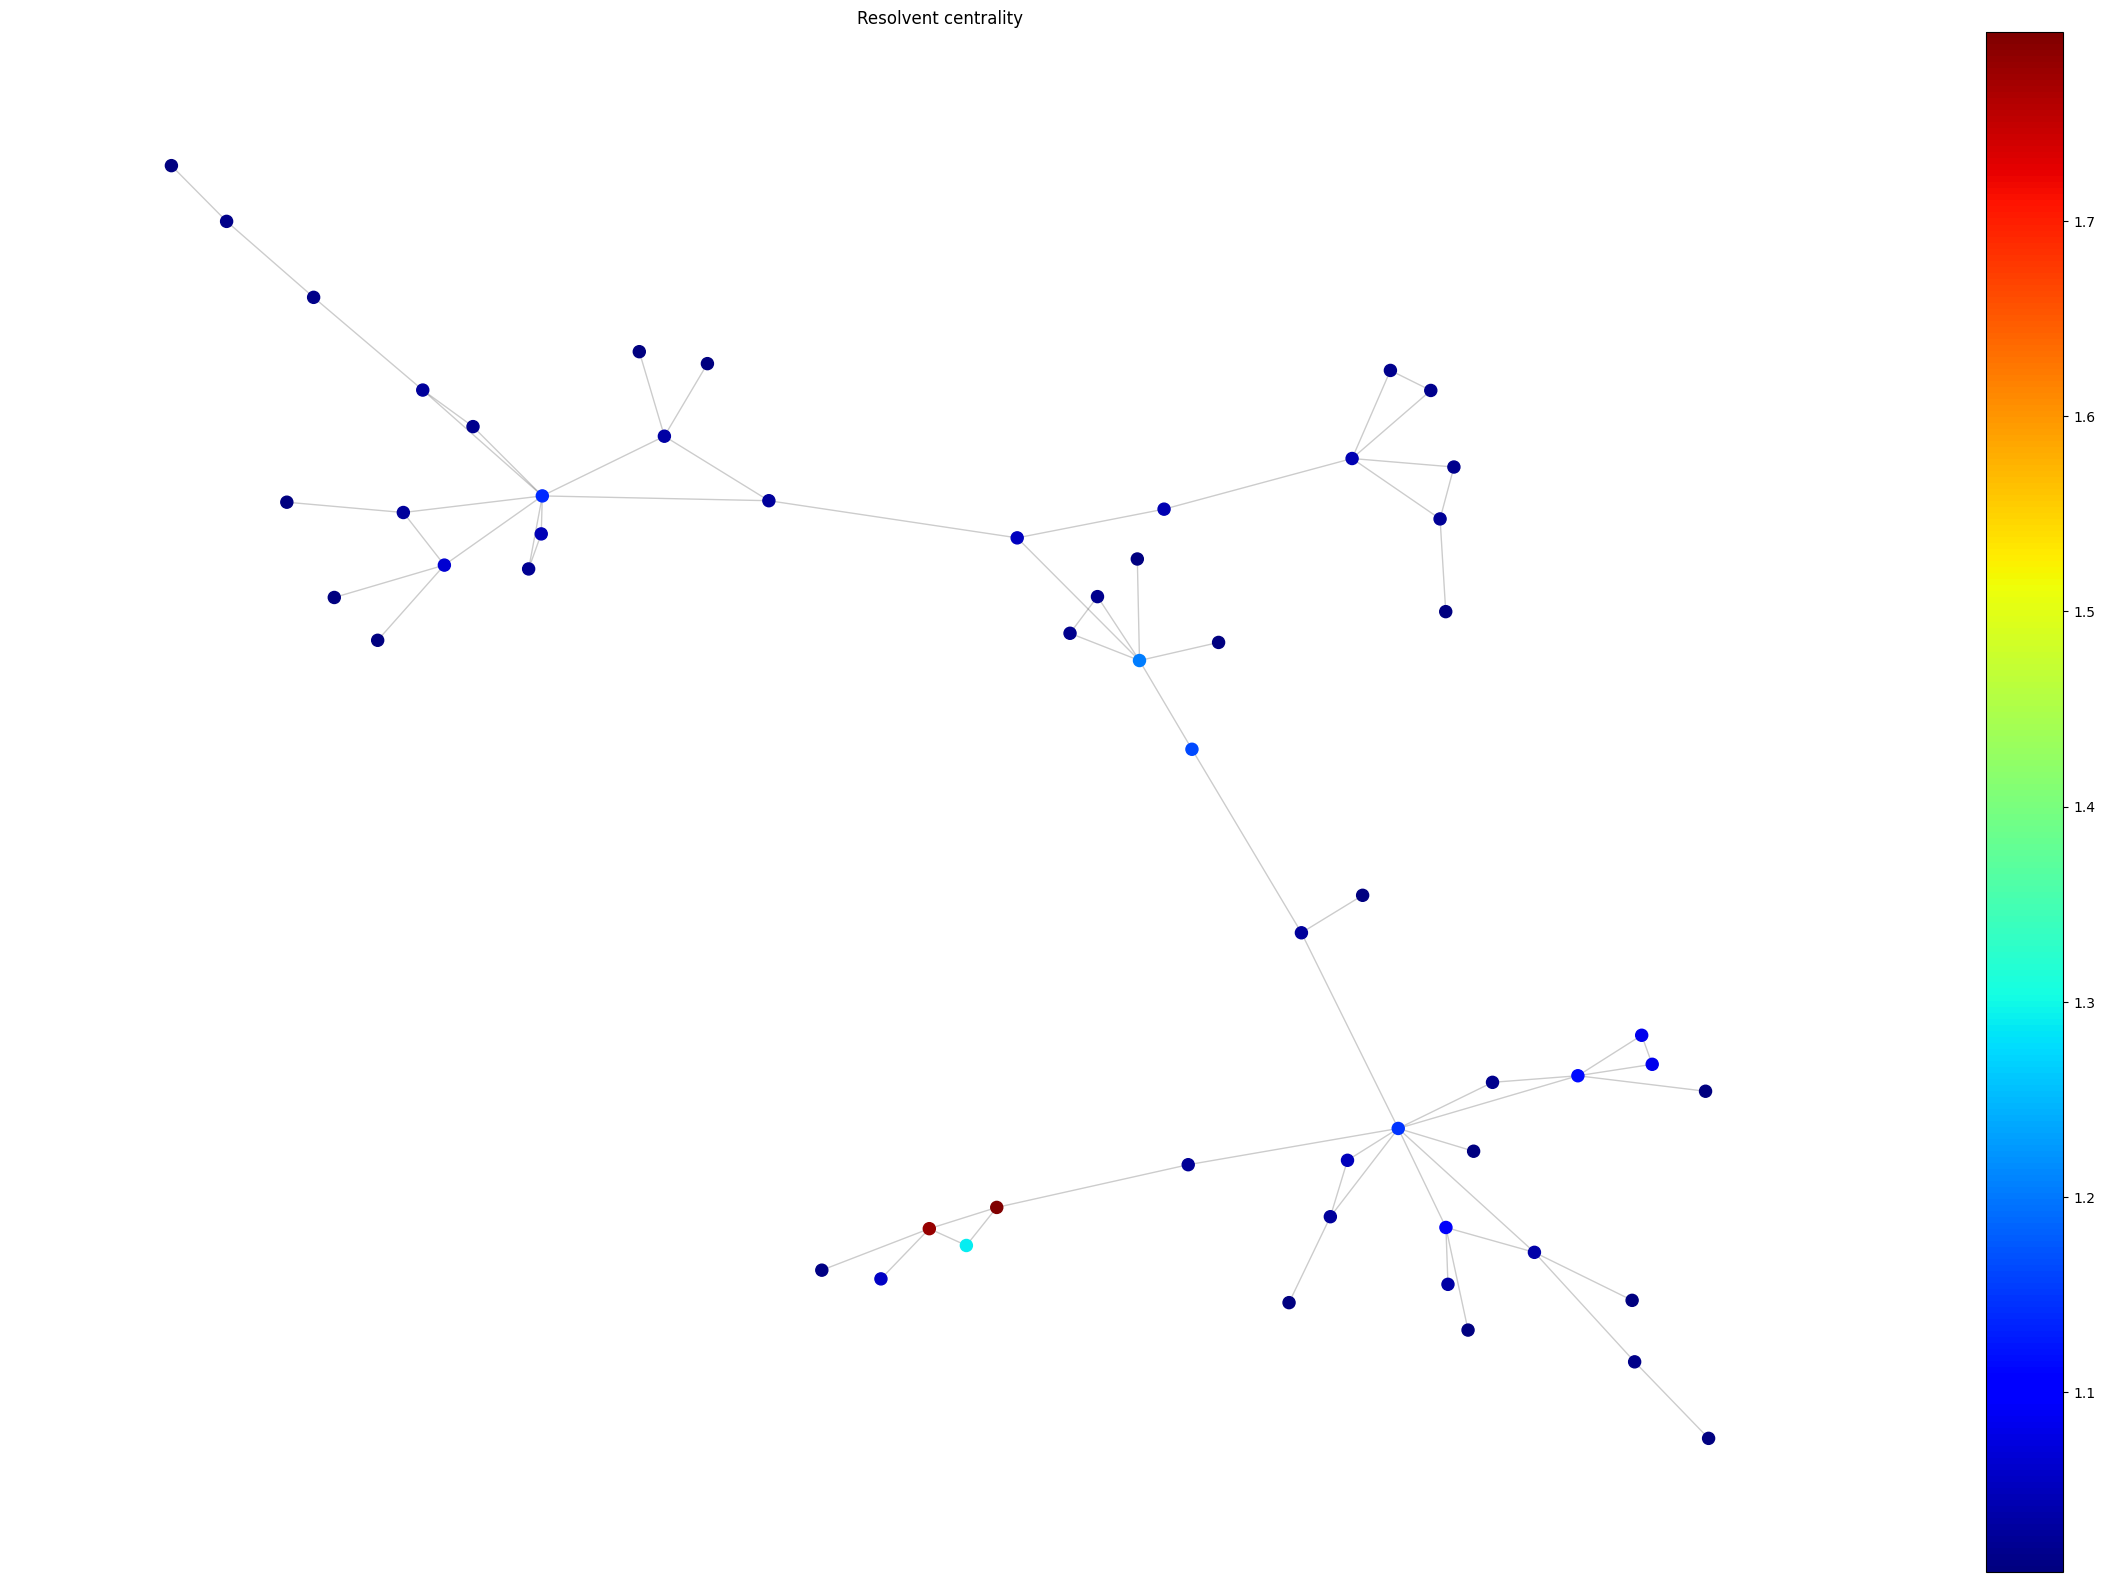

In [ ]:
t1, t2 = 2001, 2010
G_3 = builder.create_temporal_graph(t1, t2, weighted=True)
components = list(nx.connected_components(G_3))
components = sorted(components, key=len, reverse=True)
G_lcc_3 = G_3.subgraph(components[0]).copy()
alpha_3 = 0.0445 # alpha given by previous code for this time period
eigenvector_centrality_3 = get_eigenvector_centrality(G_lcc_3)
resolvent_sub_cent_3 = get_res_sub_centrality(G_lcc_3, alpha_3)
plot_eig_cent_graph(G_lcc_3, eigenvector_centrality_3 )
plot_res_cent_graph(G_lcc_3, resolvent_sub_cent_3)

**Connected components and clustering**

Spectral clustering is done using the smallest eigenvalues

In [ ]:
def get_sorted_m_smallest_eigenvalues(G, m=100):
    L = get_norm_L(G)
    vals, vecs = eigsh(L, k=m, which="SM")
    idx = np.argsort(vals)
    vals = vals[idx]
    vecs = vecs[:, idx]
    return vals, vecs

We use eigengaps to know the number of clusters for the largest connected component

In [ ]:
def get_nb_clusters(vals): # using relative eigengaps
    # why relative? Avoid giving more weight to larger part of spectrum
    m = len(vals)
    rel_gaps = []
    indices = []
    for i in range(1, m-1):
        # relative gap: (λ_{i+1} - λ_i) / max(λ_{i+1}, tiny amount), denomiator as such to avoid "division by zero"
        rel = (vals[i+1] - vals[i]) / max(vals[i+1], 1e-12)
        rel_gaps.append(rel)
        indices.append(i)

    if rel_gaps:
        best_i = indices[int(np.argmax(rel_gaps))]
        k_sugg = best_i  # number of clusters suggested by eigengap
    else:
        k_sugg = 1
    return(k_sugg)

We cluster the largest connected component using spectral clustering. The smaller connected components each also form a cluster

In [ ]:
def cluster_largest_conn_comp(G_lcc, m = 100):
    n_lcc = G_lcc.number_of_nodes()
    # Ensure m is less than n_lcc for eigsh to work
    m = min(m, n_lcc - 1) if n_lcc > 1 else 0

    if m == 0:
        # Handle the case of a single node or no nodes in LCC
        return {node: 0 for node in G_lcc.nodes()}, 1 # Treat as a single cluster

    vals, vecs = get_sorted_m_smallest_eigenvalues(G_lcc, m)
    nb_clust = get_nb_clusters(vals)

    # Ensure nb_clust is at least 1 and not more than m
    nb_clust = max(1, min(nb_clust, m))

    # use first nb_clust eigenvectors
    X = vecs[:, :nb_clust]

    # Handle cases where nb_clust is 1 (all nodes in one cluster)
    if nb_clust == 1:
         clustering = {nodes: 0 for nodes in G_lcc.nodes()}
    else:
        kmeans = KMeans(n_clusters=nb_clust, n_init=20, random_state=42) # Add random_state for reproducibility
        labels = kmeans.fit_predict(X)

        # mapping node -> cluster
        nodes = list(G_lcc.nodes())
        clustering = {nodes[i]: labels[i] for i in range(len(nodes))}

    return clustering, nb_clust

We cluster the full graph (i.e. we also add the other connected components as their own cluster)

In [ ]:
def full_graph_clustering(G, m=100):
    components = list(nx.connected_components(G))
    components = sorted(components, key=len, reverse=True)

    G_lcc = G.subgraph(components[0]).copy()
    clustering_lcc, nb_clust_lcc = cluster_largest_conn_comp(G_lcc, m=m)

    clustering = {} # keep all clusters
    clustering.update(clustering_lcc) # add clusters from largest component
    next_cluster_id = nb_clust_lcc

    for comp in components[1:]:
        for node in comp:
            clustering[node] = next_cluster_id
        next_cluster_id += 1

    return clustering, nb_clust_lcc, next_cluster_id

Plotting the clustering

In [ ]:
def draw_clustering(G, m=100):
    clustering, k_lcc, k_total = full_graph_clustering(G, m=100)

    print(f"Largest connected component split into {k_lcc} clusters")
    print(f"Total clusters: {k_total}")

    # pos = nx.spring_layout(G, seed=1)  # layout on full graph
    pos = nx.kamada_kawai_layout(G)
    colors = [clustering[node] for node in G.nodes()]

    plt.figure(figsize=(25, 15))
    nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=plt.cm.tab20, node_size=30)
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    plt.title(f"Spectral clustering")
    plt.axis("off")
    plt.show()

We want to know what those clusters mean. So we want to know what authors are in a cluster to possibly extract meaningful information (e.g. groups of authors based on the domain they study within Algebraic Topology)

We now have a mapping: clustering[node] = cluster_id (Each node gets mapped to a cluster id)

Reverse to find nodes in a cluster:

In [ ]:
def nodes_per_cluster(clustering):
    clusters = defaultdict(list)
    for node, c_id in clustering.items():
        clusters[c_id].append(node)
    return clusters

In [ ]:
def get_cluster_sizes(clustering):
  clusters = nodes_per_cluster(clustering)
  for c_id, nodes in clusters.items():
    print(f"Cluster {c_id}: {len(nodes)} nodes")

In [ ]:
def authors_in_clusters(clustering, id):
    clusters = nodes_per_cluster(clustering)
    print(f"Authors in cluster {id}:", clusters[id])

Creating graph for period [2021, 2023]: 598 publications
Largest connected component split into 2 clusters
Total clusters: 371


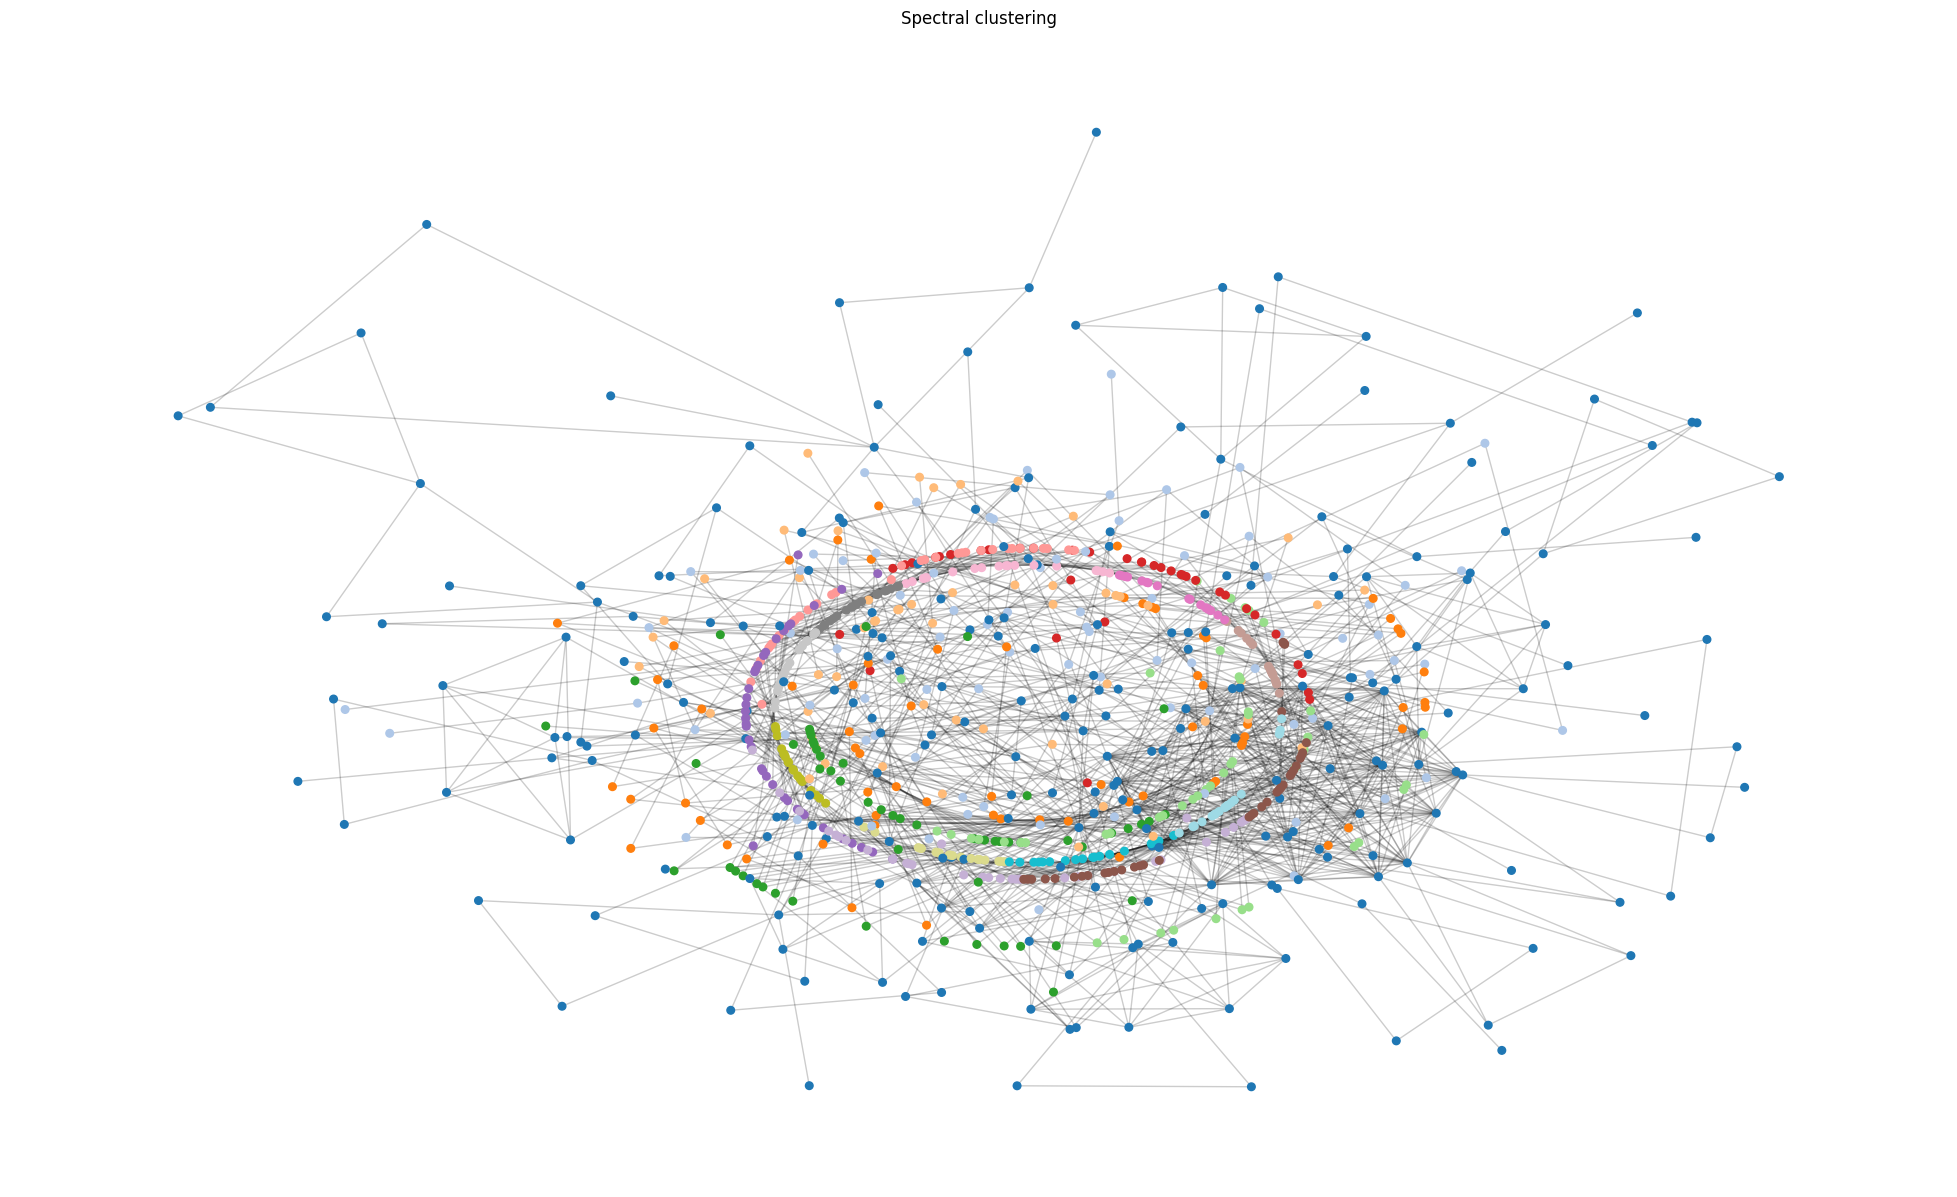

Cluster 0: 10 nodes
Cluster 1: 30 nodes
Cluster 2: 37 nodes
Cluster 3: 22 nodes
Cluster 4: 19 nodes
Cluster 5: 15 nodes
Cluster 6: 15 nodes
Cluster 7: 11 nodes
Cluster 8: 10 nodes
Cluster 9: 10 nodes
Cluster 10: 10 nodes
Cluster 11: 8 nodes
Cluster 12: 8 nodes
Cluster 13: 8 nodes
Cluster 14: 7 nodes
Cluster 15: 7 nodes
Cluster 16: 7 nodes
Cluster 17: 6 nodes
Cluster 18: 6 nodes
Cluster 19: 5 nodes
Cluster 20: 5 nodes
Cluster 21: 5 nodes
Cluster 22: 5 nodes
Cluster 23: 5 nodes
Cluster 24: 5 nodes
Cluster 25: 5 nodes
Cluster 26: 5 nodes
Cluster 27: 5 nodes
Cluster 28: 5 nodes
Cluster 29: 5 nodes
Cluster 30: 4 nodes
Cluster 31: 4 nodes
Cluster 32: 4 nodes
Cluster 33: 4 nodes
Cluster 34: 4 nodes
Cluster 35: 4 nodes
Cluster 36: 4 nodes
Cluster 37: 4 nodes
Cluster 38: 4 nodes
Cluster 39: 4 nodes
Cluster 40: 4 nodes
Cluster 41: 4 nodes
Cluster 42: 4 nodes
Cluster 43: 4 nodes
Cluster 44: 4 nodes
Cluster 45: 4 nodes
Cluster 46: 4 nodes
Cluster 47: 4 nodes
Cluster 48: 4 nodes
Cluster 49: 3 nodes

In [ ]:
t1, t2 = 2021, 2023
G_1 = builder.create_temporal_graph(t1, t2, weighted=True)
clustering_1, nb_clust_lcc_1, next_cluster_id_1 = full_graph_clustering(G_1, m=100)
draw_clustering(G_1)
clusters_1 = nodes_per_cluster(clustering_1)
get_cluster_sizes(clustering_1)

In [ ]:
id_1 = 6 # something
authors_in_clusters(clustering_1, id_1)

Authors in cluster 6: ['Vasileios Maroulas', 'Piotr J Franaszczuk', 'Farzana Nasrin', 'Scott Kerick', 'Christopher Oballe', 'Dan Yasaki', 'Theodore Papamarkou', 'Alan Cherne', 'Neil Pritchard', 'Dave Boothe', 'Yu-min Chung', 'Orlando Rios', 'Austin Lawson', 'Greg Bell', 'Na Gong']


Creating graph for period [2001, 2010]: 1418 publications
Largest connected component split into 1 clusters
Total clusters: 628


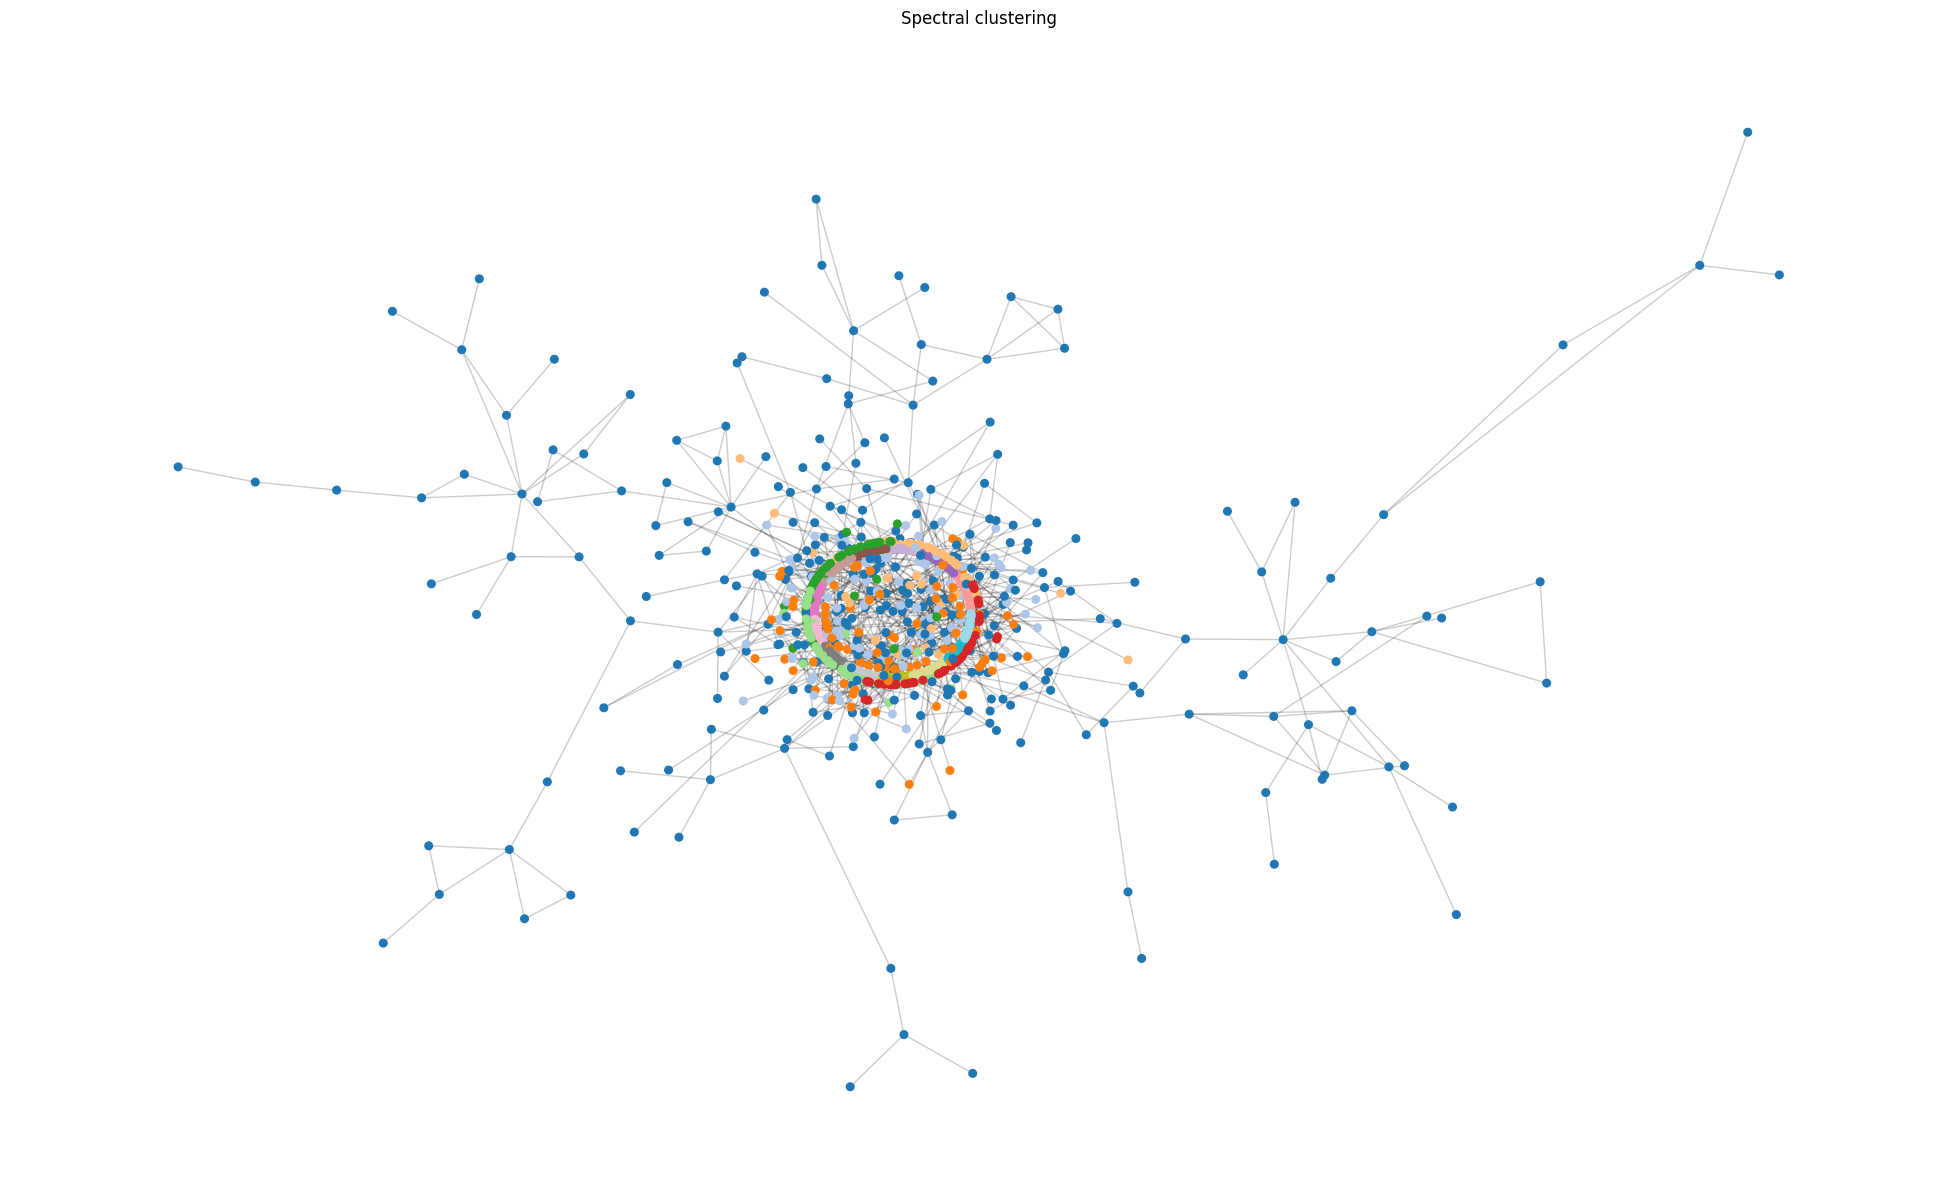

Cluster 0: 56 nodes
Cluster 1: 50 nodes
Cluster 2: 34 nodes
Cluster 3: 19 nodes
Cluster 4: 18 nodes
Cluster 5: 10 nodes
Cluster 6: 10 nodes
Cluster 7: 9 nodes
Cluster 8: 9 nodes
Cluster 9: 9 nodes
Cluster 10: 8 nodes
Cluster 11: 7 nodes
Cluster 12: 7 nodes
Cluster 13: 6 nodes
Cluster 14: 6 nodes
Cluster 15: 5 nodes
Cluster 16: 5 nodes
Cluster 17: 5 nodes
Cluster 18: 5 nodes
Cluster 19: 5 nodes
Cluster 20: 5 nodes
Cluster 21: 5 nodes
Cluster 22: 4 nodes
Cluster 23: 4 nodes
Cluster 24: 4 nodes
Cluster 25: 4 nodes
Cluster 26: 4 nodes
Cluster 27: 4 nodes
Cluster 28: 4 nodes
Cluster 29: 4 nodes
Cluster 30: 4 nodes
Cluster 31: 4 nodes
Cluster 32: 4 nodes
Cluster 33: 4 nodes
Cluster 34: 4 nodes
Cluster 35: 4 nodes
Cluster 36: 4 nodes
Cluster 37: 4 nodes
Cluster 38: 4 nodes
Cluster 39: 4 nodes
Cluster 40: 3 nodes
Cluster 41: 3 nodes
Cluster 42: 3 nodes
Cluster 43: 3 nodes
Cluster 44: 3 nodes
Cluster 45: 3 nodes
Cluster 46: 3 nodes
Cluster 47: 3 nodes
Cluster 48: 3 nodes
Cluster 49: 3 nodes
Clu

In [ ]:
t1, t2 = 2001, 2010
G_2 = builder.create_temporal_graph(t1, t2, weighted=True)
clustering_2, nb_clust_lcc_2, next_cluster_id_2 = full_graph_clustering(G_2, m=100)
draw_clustering(G_2)
clusters_2 = nodes_per_cluster(clustering_2)
get_cluster_sizes(clustering_2)

In [ ]:
id_2 = 1 # something
authors_in_clusters(clustering_2, id_2)

Authors in cluster 1: ['Toshitake Kohno', 'Peter Bouwknegt', 'Mark Grant', 'Daniel C Cohen', 'David Eisenbud', 'Jon F Carlson', 'Julius L Shaneson', 'Yasuhiko Kamiyama', 'Yongbin Ruan', 'Keith Hannabuss', 'Markus Banagl', 'Jianquan Ge', 'Ernesto Lupercio', 'Ş Papadima', 'Edward Becerra', 'Jean-paul Brasselet', 'Shengda Hu', 'Varghese Mathai', 'Ross Geoghegan', 'A D R Choudary', 'Stefan Papadima', 'Alexander Caviedes', 'Peter Orlik', 'Graham Denham', 'Sergey Yuzvinsky', 'Lev Borisov', 'Alexandru Dimca', 'Yun Feng Jiang', 'Sorin Popescu', 'Johann Leida', 'Alexander I Suciu', 'Fred Cohen', 'Laurentiu Maxim', 'Maxim Braverman', 'Anatoly Libgober', 'Lev Birbrair', 'Peter J Eccles', 'Henning Krause', 'Fan Ding', 'Michael Farber', 'Alan Carey', 'Xicoté', 'Sylvain E Cappell', 'Jian Zhong Pan', 'Alejandro Adem', 'Jeff H Smith', 'Schü', 'Jianzhong Pan', 'Nansen Petrosyan', 'Bernardo Uribe']


In [ ]:
def get_publications_for_authors(publications, authors, t1, t2):
    filtered_pubs = []
    for pub in publications:
        if pub['year'] and t1 <= pub['year'] <= t2:
            # Check if any of the authors in the cluster are in the publication's author list
            if any(author in pub['authors'] for author in authors):
                filtered_pubs.append(pub)
    return filtered_pubs


cluster_authors_1 = clusters_2[1]
cluster_publications_1 = get_publications_for_authors(publications, cluster_authors_1, 2001, 2010)

print(f"Publications for authors in Cluster 1 (2001-2010):")
for pub in cluster_publications_1:
    print(f"  - {pub['title']} ({pub['year']})")

print("-" * 20) # Separator

cluster_6_authors = clusters_1[6]
cluster_6_publications = get_publications_for_authors(publications, cluster_6_authors, 2021, 2023)

print(f"Publications for authors in Cluster 6 (2021-2023):")
if cluster_6_publications:
    for pub in cluster_6_publications:
        print(f"  - {pub['title']} ({pub['year']})")
else:
    print("No publications found for authors in Cluster 6 during this period.")

Publications for authors in Cluster 1 (2001-2010):
  - Inertia orbifolds, configuration spaces and the ghost loop space (2004)
  - Hodge genera and characteristic classes of complex algebraic varieties (2008)
  - Homological category weights and estimates for cat (2008)
  - Topology of random linkages (2008)
  - Mini-workshop: Topology (2007)
  - Configurations and parallelograms associated to centers of mass (2007)
  - Symmetric motion planning (2007)
  - On the isotropic subspace theorems (2008)
  - The signature of partially defined local coefficient systems (2008)
  - Hodge-theoretic Atiyah (2008)
  - Intersection cohomology invariants of complex algebraic varieties (2008)
  - Compatible actions and cohomology of crystallographic groups. (2008)
  - Rational generalized intersection homology theories (2010)
  - The Chen (2010)
  - Chern-Weil (2010)
  - Singular spaces and generalized Poincaré (2009)
  - Geometric and algebraic aspects of 1 (2009)
  - Stringy product on twisted orbif

In [ ]:
cluster_4_authors = clusters_1[4]
cluster_4_publications = get_publications_for_authors(publications, cluster_4_authors, 2021, 2023)

print(f"Publications for authors in Cluster 4 (2021-2023):")
if cluster_4_publications:
    for pub in cluster_4_publications:
        print(f"  - {pub['title']} ({pub['year']})")
else:
    print("No publications found for authors in Cluster 4 during this period.")

Publications for authors in Cluster 4 (2021-2023):
  - Distances and isomorphism between networks: stability and convergence of network invariants (2023)
  - Morse inequalities for the Koszul (2023)
  - Generalized persistence diagrams for persistence modules over posets (2021)
  - The Reeb (2021)
  - Improved approximate Rips (2021)
  - Ripser: efficient computation of Vietoris (2021)
  - Spatiotemporal persistent homology for dynamic metric spaces (2021)
  - Elder-rule-staircodes for augmented metric spaces (2021)
  - Persistent Laplacians (2022)
  - Compression for 2 (2023)
  - Persistent homology: a topological tool for higher-interaction systems (2022)
  - Relative-perfectness of discrete gradient vector fields and multi-parameter persistent homology (2022)
  - Morse-based fibering of the persistence rank invariant (2022)
  - Analysis of contagion maps on a class of networks that are spatially embedded in a torus (2021)
  - Computing invariants for multipersistence via spectral sy

In [ ]:
cluster_5_authors = clusters_1[5]
cluster_5_publications = get_publications_for_authors(publications, cluster_5_authors, 2021, 2023)

print(f"Publications for authors in Cluster 5 (2021-2023):")
if cluster_5_publications:
    for pub in cluster_5_publications:
        print(f"  - {pub['title']} ({pub['year']})")
else:
    print("No publications found for authors in Cluster 5 during this period.")

Publications for authors in Cluster 5 (2021-2023):
  - Level structures on p (2023)
  - Picard groups and duality for real Morava (2021)
  - Monochromatic homotopy theory is asymptotically algebraic (2021)
  - Models of Lubin (2021)
  - Supersymmetric field theories and the elliptic index theorem with complex coefficients (2021)
  - Constructing the determinant sphere using a Tate (2022)
  - On conjectures of Hovey (2022)
  - The localized slice spectral sequence, norms of real bordism, and the Segal (2023)
  - Power operations in the Stolz (2022)
  - Tate blueshift and vanishing for real oriented cohomology theories (2022)
  - A de Rham (2021)
  - Topological modular forms with level structure: decompositions and duality (2022)
  - Equivariant elliptic cohomology, gauged sigma models, and discrete torsion (2022)
  - Quotient rings of H𝔽 (2021)


### Most common words in publications

In [ ]:
from collections import Counter
import re

def get_most_common_words_in_titles(publications, authors, t1, t2, num_words=20):
    """
    Gets the most common words from publication titles for a given set of authors
    within a specific time period.
    """
    filtered_pubs = get_publications_for_authors(publications, authors, t1, t2)
    all_words = []
    # Regex pattern to split words and remove punctuation
    word_pattern = re.compile(r'\W+')

    for pub in filtered_pubs:
        if pub['title']:
            words = word_pattern.split(pub['title'].lower())
            all_words.extend([word for word in words if word and len(word) > 3]) # Exclude short words

    word_counts = Counter(all_words)
    return word_counts.most_common(num_words)

# Make sure clustering_1, publications, and time_windows are available from previous cells
if 'clustering_1' in locals() and 'publications' in locals() and 'time_windows' in locals():
    # Find the time window for clustering_1
    t1, t2 = time_windows[-1]
    cluster_id_to_analyze = 6 # Example: cluster ID

    if cluster_id_to_analyze in clusters_1:
        authors_in_cluster = clusters_1[cluster_id_to_analyze]
        most_common_words = get_most_common_words_in_titles(publications, authors_in_cluster, t1, t2)

        print(f"Most common words in publication titles for Cluster {cluster_id_to_analyze} ({t1}-{t2}):")
        for word, count in most_common_words:
            print(f"- {word} ({count})")
    else:
        print(f"Cluster {cluster_id_to_analyze} not found in clustering_1 data.")
else:
    print("Please ensure clustering_1, publications, and time_windows are defined by running previous cells.")

Most common words in publication titles for Cluster 6 (2021-2023):
- persistence (4)
- diagrams (2)
- space (1)
- fails (1)
- have (1)
- bayesian (1)
- topological (1)
- signal (1)
- processing (1)
- random (1)
- diagram (1)
- generator (1)
- curves (1)
- canonical (1)
- framework (1)
- summarizing (1)


Analyzing some clusters from the first time period (1936-1960):

Creating graph for period [1936, 1960]: 15 publications
Largest connected component split into 1 clusters
Total clusters: 13


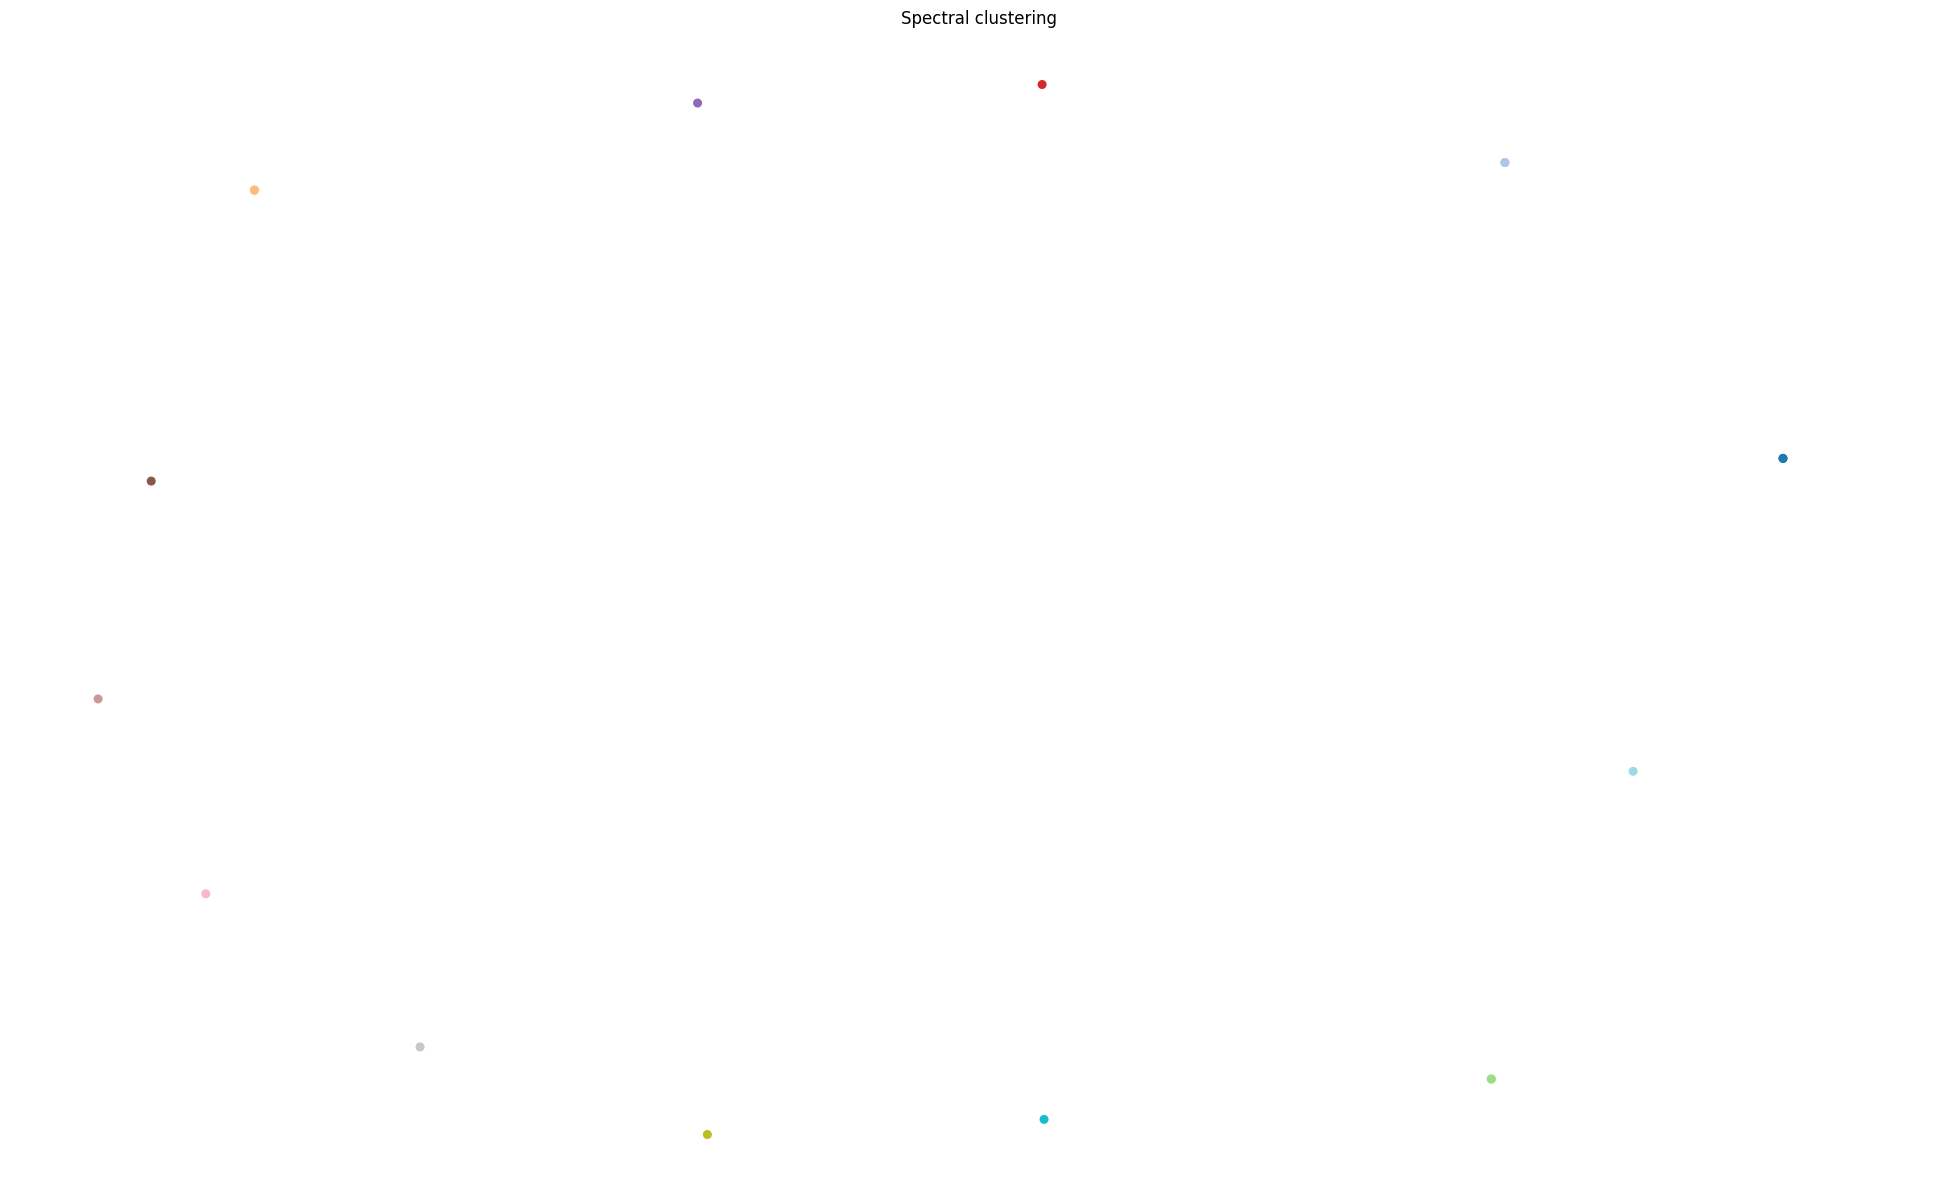

Cluster 0: 2 nodes
Cluster 1: 2 nodes
Cluster 2: 2 nodes
Cluster 3: 2 nodes
Cluster 4: 1 nodes
Cluster 5: 1 nodes
Cluster 6: 1 nodes
Cluster 7: 1 nodes
Cluster 8: 1 nodes
Cluster 9: 1 nodes
Cluster 10: 1 nodes
Cluster 11: 1 nodes
Cluster 12: 1 nodes


In [ ]:
t1, t2 = 1936, 1960
G_3 = builder.create_temporal_graph(t1, t2, weighted=True)
clustering_3, nb_clust_lcc_3, next_cluster_id_3 = full_graph_clustering(G_3, m=100)
draw_clustering(G_3)
clusters_3 = nodes_per_cluster(clustering_3)
get_cluster_sizes(clustering_3)

In [ ]:
id_list = [0,1,2,3,4,5]
for id in id_list:
  authors = authors_in_clusters(clustering_3, id)

Authors in cluster 0: ['Patrick Shanahan', 'J W T Youngs']
Authors in cluster 1: ['Peter J Hilton', 'S Wylie']
Authors in cluster 2: ['E A Barbashin', 'V A Bajdosov']
Authors in cluster 3: ['Everett Pitcher', 'J L Kelley']
Authors in cluster 4: ['Paul A Smith']
Authors in cluster 5: ['Alexandre Grothendieck']


In [ ]:
for id in id_list:
  cluster_authors = clusters_3[id]
  cluster_publications = get_publications_for_authors(publications, cluster_authors, 1936, 1960)

  print(f"Publications for authors in Cluster {id} (1936-1960):")
  if cluster_publications:
      for pub in cluster_publications:
          print(f"  - {pub['title']} ({pub['year']})")
  else:
      print("No publications found for authors in Cluster {id} during this period.")


Publications for authors in Cluster 0 (1936-1960):
  - An axiomatic characterization of the reduced homology theory (1960)
Publications for authors in Cluster 1 (1936-1960):
  - Homology theory. An (1960)
Publications for authors in Cluster 2 (1936-1960):
  - Zur Frage (1958)
Publications for authors in Cluster 3 (1936-1960):
  - Exact homomorphism sequences in homology theory (1947)
Publications for authors in Cluster 4 (1936-1960):
  - Orbit spaces of abelian p-groups (1959)
Publications for authors in Cluster 5 (1936-1960):
  - Duality theorem for algebraic coherent sheaves. (1959)
